# BitcoinVision - Evan Millikan TP049195

In [1]:
# Install Module

# !pip install ipynb 
# !pip install keras
# !pip install tensorflow

In [1]:
# Import Statements

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import ipynb.fs.full.blockchain_api as blockchain_data
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler
from numpy import concatenate
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
warnings.filterwarnings('ignore') 

In [3]:
# API Call to get Blockchain Data

# blockchain_data.get_block_details(dir='./resource/block_details/')
# blockchain_data.get_market_signals(dir='./resource/market_signals/')
# blockchain_data.get_mining_information(dir='./resource/mining_information/')
# blockchain_data.get_network_activity(dir='./resource/network_actvity/')
# blockchain_data.get_wallet_activity(dir='./resource/wallet_activity/')

# Data Understanding

## 1. Bitcoin Price

In [4]:
bitcoin_price = pd.read_csv('./resource/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
bitcoin_price['Timestamp'] = pd.to_datetime(bitcoin_price.Timestamp, unit='s')
bitcoin_price.index = bitcoin_price['Timestamp']
bitcoin_price = bitcoin_price.drop(columns=['Timestamp'])

bitcoin_price

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2021-03-30 23:56:00,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
2021-03-30 23:57:00,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
2021-03-30 23:58:00,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496


Because the data dates back as early as 2011, there is very little transaction happening in the beginning of the data thus producing a lot of NaN (Null) values whereas the more recent data has transaction happening every minutes.

In [5]:
bitcoin_price.isnull().sum()

Open                 1243608
High                 1243608
Low                  1243608
Close                1243608
Volume_(BTC)         1243608
Volume_(Currency)    1243608
Weighted_Price       1243608
dtype: int64

bitcoin_price_day shape: (3379, 7)
bitcoin_price_week shape: (484, 7)
bitcoin_price_month shape: (112, 7)
bitcoin_price_3month shape: (38, 7)


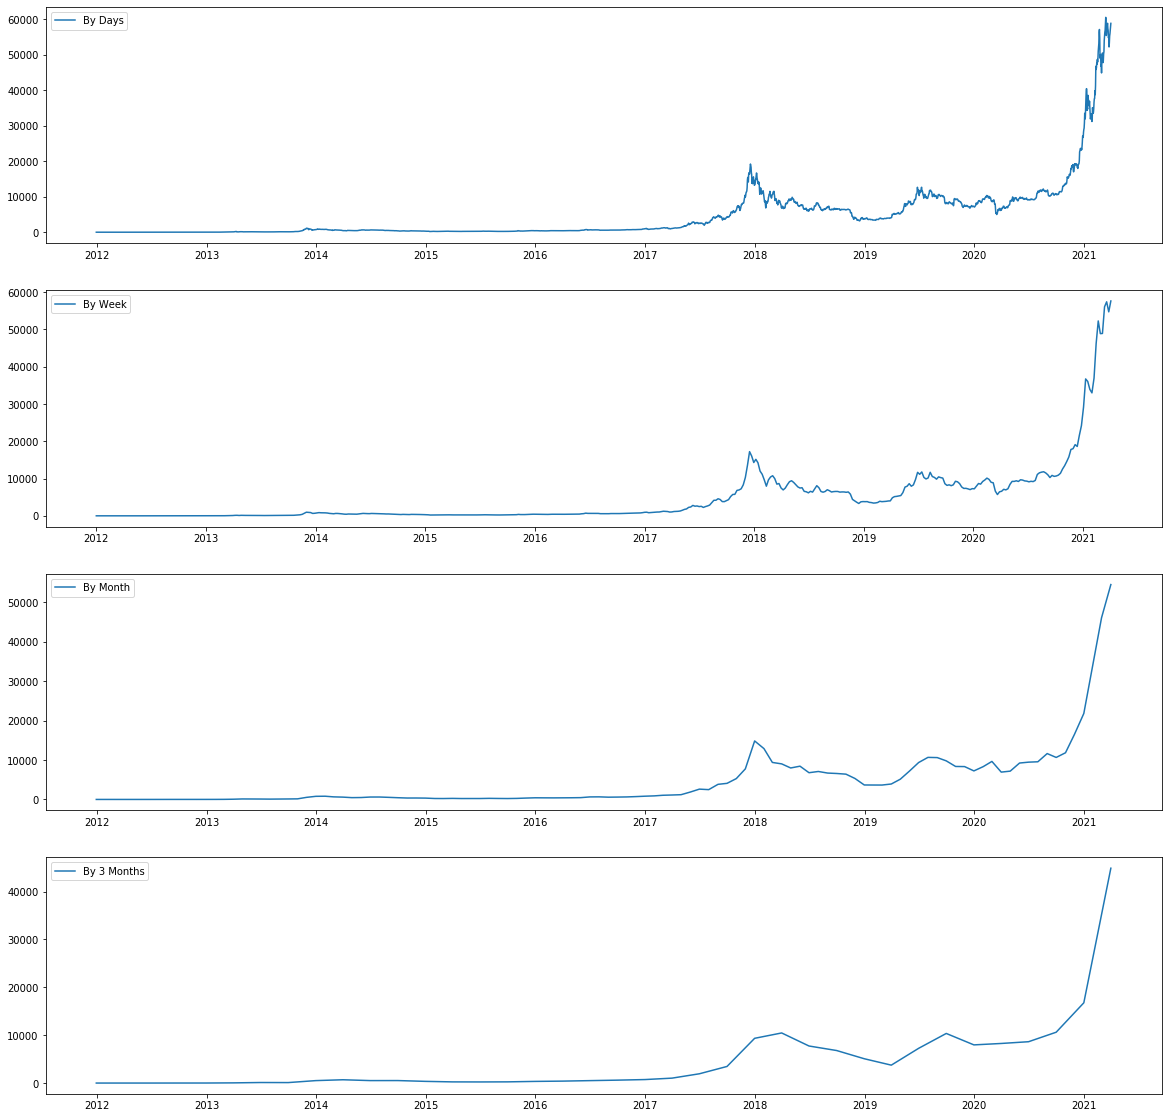

In [6]:
# Plotting Resampled Weighted Price

bitcoin_price_day = bitcoin_price.resample('D').mean()
print(f'bitcoin_price_day shape: {bitcoin_price_day.shape}')
bitcoin_price_week = bitcoin_price.resample('W').mean()
print(f'bitcoin_price_week shape: {bitcoin_price_week.shape}')
bitcoin_price_month = bitcoin_price.resample('M').mean()
print(f'bitcoin_price_month shape: {bitcoin_price_month.shape}')
bitcoin_price_3month = bitcoin_price.resample('3M').mean()
print(f'bitcoin_price_3month shape: {bitcoin_price_3month.shape}')

fig, axes = plt.subplots(4, 1, figsize=(20, 20))

sns.lineplot(ax=axes[0], data=bitcoin_price_day.Weighted_Price, label='By Days')

sns.lineplot(ax=axes[1], data=bitcoin_price_week.Weighted_Price, label='By Week')

sns.lineplot(ax=axes[2], data=bitcoin_price_month.Weighted_Price, label='By Month')

sns.lineplot(ax=axes[3], data=bitcoin_price_3month.Weighted_Price, label='By 3 Months')

plt.show()

## 2. Block Details (Bitcoin Blockchain Information)

|        Column Name       |                                                    Description                                                    |
|:------------------------:|:-----------------------------------------------------------------------------------------------------------------:|
|        block-size        |                       The total size of the blockchain minus database indexes in megabytes.                       |
|      avg-block-size      |                            The average block size over the past 24 hours in megabytes.                            |
| median-confirmation-time | The median time for a transaction with miner fees to be included in a mined block and added to the public ledger. |
|  n-transaction-per-block |                        The average number of transactions per block over the past 24 hours.                       |
|   n-transactions-total   |                                The total number of transactions on the blockchain.                                |

In [7]:
avg_block_size = pd.read_csv('./resource/block_details/avg-block-size')
block_size = pd.read_csv('./resource/block_details/blocks-size')
median_confirmation_time = pd.read_csv('./resource/block_details/median-confirmation-time')
n_transactions_per_block = pd.read_csv('./resource/block_details/n-transactions-per-block')
n_transactions_total = pd.read_csv('./resource/block_details/n-transactions-total')
temp_block_details = pd.concat([
    avg_block_size,
    block_size,
    median_confirmation_time,
    n_transactions_per_block,
    n_transactions_total,
], axis=1)
temp_block_details

,Timestamp,avg-block-size,Timestamp,blocks-size,Timestamp,median-confirmation-time,Timestamp,n-transactions-per-block,Timestamp,n-transactions-total
0,2011-12-31 00:00:00,0.016243,2011-12-31 00:00:00,859.493705,2011-12-31 00:00:00,12.133333,2011-12-31 00:00:00,34.019868,2011-12-31 00:00:00,2114742.0
1,2012-01-01 00:00:00,0.017073,2012-01-01 00:00:00,861.941752,2012-01-01 00:00:00,15.050000,2012-01-01 00:00:00,32.686275,2012-01-01 00:00:00,2119853.0
2,2012-01-02 00:00:00,0.019121,2012-01-02 00:00:00,864.547504,2012-01-02 00:00:00,15.566667,2012-01-02 00:00:00,35.827815,2012-01-02 00:00:00,2124845.0
3,2012-01-03 00:00:00,0.018212,2012-01-03 00:00:00,867.445999,2012-01-03 00:00:00,13.616667,2012-01-03 00:00:00,36.308176,2012-01-03 00:00:00,2130220.0
4,2012-01-04 00:00:00,0.019351,2012-01-04 00:00:00,870.374487,2012-01-04 00:00:00,13.616667,2012-01-04 00:00:00,38.463087,2012-01-04 00:00:00,2135991.0
...,...,...,...,...,...,...,...,...,...,...
3425,2021-05-17 00:00:00,1.334122,2021-05-17 00:00:00,345630.188158,2021-05-17 00:00:00,11.000000,2021-05-17 00:00:00,2073.636364,2021-05-17 00:00:00,642762772.0
3426,2021-05-18 00:00:00,1.332187,2021-05-18 00:00:00,345792.055966,2021-05-18 00:00:00,14.975000,2021-05-18 00:00:00,2210.180000,2021-05-18 00:00:00,643014160.0
3427,2021-05-19 00:00:00,1.322286,2021-05-19 00:00:00,345925.142902,2021-05-19 00:00:00,14.033333,2021-05-19 00:00:00,2107.352000,2021-05-19 00:00:00,643235634.0
3428,2021-05-20 00:00:00,1.304127,2021-05-20 00:00:00,346090.308707,2021-05-20 00:00:00,11.450000,2021-05-20 00:00:00,2036.062500,2021-05-20 00:00:00,643498821.0


In [8]:
temp_block_details.isnull().any()

Timestamp                   False
avg-block-size              False
Timestamp                   False
blocks-size                 False
Timestamp                   False
median-confirmation-time    False
Timestamp                   False
n-transactions-per-block    False
Timestamp                   False
n-transactions-total        False
dtype: bool

In [9]:
avg_block_size = pd.read_csv('./resource/block_details/avg-block-size', index_col='Timestamp')
block_size = pd.read_csv('./resource/block_details/blocks-size', index_col='Timestamp')
median_confirmation_time = pd.read_csv('./resource/block_details/median-confirmation-time', index_col='Timestamp')
n_transactions_per_block = pd.read_csv('./resource/block_details/n-transactions-per-block', index_col='Timestamp')
n_transactions_total = pd.read_csv('./resource/block_details/n-transactions-total', index_col='Timestamp')
block_details_list = [avg_block_size, block_size, median_confirmation_time, n_transactions_per_block, n_transactions_total]

## 3. Market Signals (Bitcoin Blockchain Information)

|              Column Name             |                                                                                      Description                                                                                      |
|:------------------------------------:|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
|    Market Value to Realised Value    | MVRV is calculated by dividing Market Value by Realised Value. In Realised Value, BTC prices are taken at the time they last moved, instead of the current price like in Market Value |
|     Network Value to Transactions    |                              NVT is computed by dividing the Network Value (= Market Value) by the total transactions volume in USD over the past 24hour.                             |
| Network Value to Transactions Signal |                             NVTS is a more stable measure of NVT, with the denominator being the moving average over the last 90 days of NVT's denominator                            |

In [10]:
market_value_to_realised_value = pd.read_csv('./resource/market_signals/mvrv')
network_value_to_transactions = pd.read_csv('./resource/market_signals/nvt')
network_value_to_transactions_signal = pd.read_csv('./resource/market_signals/nvts')
market_signals_list = [market_value_to_realised_value, network_value_to_transactions, network_value_to_transactions_signal]

In [11]:
market_value_to_realised_value

,Timestamp,mvrv
0,2011-12-31 00:02:50,0.857869
1,2011-12-31 00:04:55,0.857868
2,2011-12-31 00:08:48,0.857867
3,2011-12-31 00:17:49,0.857865
4,2011-12-31 00:18:01,0.857863
...,...,...
508553,2021-05-22 01:39:27,1.899865
508554,2021-05-22 01:43:56,1.899870
508555,2021-05-22 01:58:45,1.899968
508556,2021-05-22 02:36:28,1.897854


In [12]:
network_value_to_transactions

,Timestamp,nvt
0,2011-12-31 00:02:50,28.640726
1,2011-12-31 00:04:55,28.603581
2,2011-12-31 00:08:48,28.987341
3,2011-12-31 00:17:49,28.922169
4,2011-12-31 00:18:01,28.859197
...,...,...
508346,2021-05-20 04:25:28,6.214003
508347,2021-05-20 04:27:06,6.205756
508348,2021-05-20 05:05:46,6.365673
508349,2021-05-20 05:52:14,6.487999


In [13]:
network_value_to_transactions_signal

,Timestamp,nvts
0,2011-12-31 00:02:50,9.430827
1,2011-12-31 00:04:55,9.431427
2,2011-12-31 00:08:48,9.432031
3,2011-12-31 00:17:49,9.432633
4,2011-12-31 00:18:01,9.433235
...,...,...
508346,2021-05-20 04:25:28,7.653372
508347,2021-05-20 04:27:06,7.653238
508348,2021-05-20 05:05:46,7.851442
508349,2021-05-20 05:52:14,7.851948


## 4. Mining Information (Bitcoin Blockchain Information)

|          Column Name         |                                                Description                                                |
|:----------------------------:|:---------------------------------------------------------------------------------------------------------:|
|     cost-per-transaction     |                   A chart showing miners revenue divided by the number of transactions.                   |
| cost-per-transaction-percent |                  A chart showing miners revenue as percentage of the transaction volume.                  |
|          difficulty          |             A relative measure of how difficult it is to mine a new block for the blockchain.             |
|   fees-usd-per-transaction   |                              Average transaction fees in USD per transaction.                             |
|           hash-rate          |   The estimated number of terahashes per second the bitcoin network is performing in the last 24 hours.   |
|        miners-revenue        |                 Total value of coinbase block rewards and transaction fees paid to miners.                |
|       transaction-fees       | The total BTC value of all transaction fees paid to miners. This does not include coinbase block rewards. |
|     transaction-fees-usd     | The total USD value of all transaction fees paid to miners. This does not include coinbase block rewards. |

In [14]:
cost_per_transaction = pd.read_csv('./resource/mining_information/cost-per-transaction', index_col='Timestamp')
cost_per_transaction_percent = pd.read_csv('./resource/mining_information/cost-per-transaction-percent', index_col='Timestamp')
difficulty = pd.read_csv('./resource/mining_information/difficulty', index_col='Timestamp')
fees_usd_per_transaction = pd.read_csv('./resource/mining_information/fees-usd-per-transaction', index_col='Timestamp')
hash_rate = pd.read_csv('./resource/mining_information/hash-rate', index_col='Timestamp')
miners_revenue = pd.read_csv('./resource/mining_information/miners-revenue', index_col='Timestamp')
transaction_fees = pd.read_csv('./resource/mining_information/transaction-fees', index_col='Timestamp')
transaction_fees_usd = pd.read_csv('./resource/mining_information/transaction-fees-usd', index_col='Timestamp')
mining_information_list = [cost_per_transaction, cost_per_transaction_percent, difficulty, fees_usd_per_transaction, 
                           hash_rate, miners_revenue, transaction_fees, transaction_fees_usd]

In [15]:
mining_information_temp = pd.concat([
    cost_per_transaction,
    cost_per_transaction_percent,
    difficulty,
    fees_usd_per_transaction,
    hash_rate,
    miners_revenue,
    transaction_fees,
    transaction_fees_usd,
], axis=1)
mining_information_temp

,cost-per-transaction,cost-per-transaction-percent,difficulty,fees-usd-per-transaction,hash-rate,miners-revenue,transaction-fees,transaction-fees-usd
2011-12-31 00:00:00,6.583145,9.138363,1.159929e+06,0.003452,9.283326e+00,3.510791e+04,3.945408,1.841019e+01
2012-01-01 00:00:00,7.910605,4.193102,1.159929e+06,0.003438,8.591401e+00,4.260652e+04,3.554281,1.851638e+01
2012-01-02 00:00:00,8.429764,8.391786,1.159929e+06,0.004815,8.764382e+00,6.301249e+04,5.553122,3.598932e+01
2012-01-03 00:00:00,7.434321,7.722457,1.159929e+06,0.004872,9.340986e+00,4.662806e+04,5.352158,3.056013e+01
2012-01-04 00:00:00,7.544980,6.279210,1.159929e+06,0.012517,8.879703e+00,4.706558e+04,14.195877,7.808277e+01
...,...,...,...,...,...,...,...,...
2021-05-15 00:00:00,174.286762,0.987354,2.504649e+13,13.125969,1.531433e+08,4.138683e+07,62.457688,3.116945e+06
2021-05-16 00:00:00,190.074887,0.728477,2.504649e+13,11.234779,1.643489e+08,4.170908e+07,52.094144,2.465304e+06
2021-05-17 00:00:00,146.966607,0.365097,2.504649e+13,13.440470,1.506532e+08,3.687539e+07,76.189070,3.372348e+06
2021-05-18 00:00:00,138.579967,NaN,2.504649e+13,13.405788,1.245068e+08,3.062867e+07,67.164874,2.962920e+06


In [16]:
mining_information_temp.isnull().sum()

cost-per-transaction            0
cost-per-transaction-percent    1
difficulty                      0
fees-usd-per-transaction        0
hash-rate                       0
miners-revenue                  0
transaction-fees                0
transaction-fees-usd            0
dtype: int64

## 5. Network Activity (Bitcoin Blockchain Information)

|            Column Name           |                                                     Description                                                     |
|:--------------------------------:|:-------------------------------------------------------------------------------------------------------------------:|
|   estimated-transaction-volume   | The total estimated value in BTC of transactions on the blockchain. This does not include coins returned as change. |
| estimated-transaction-volume-usd | The total estimated value in USD of transactions on the blockchain. This does not include coins returned as change. |
|          n-transactions          |                                 The total number of confirmed transactions per day.                                 |
| n-transactions-excluding-popular |         The total number of transactions excluding those involving the network's 100 most popular addresses.        |
|        n-unique-addresses        |                             The total number of unique addresses used on the blockchain.                            |
|           output-volume          |      The total value of all transaction outputs per day. This includes coins returned to the sender as change.      |


In [17]:
estimated_transaction_volume = pd.read_csv('./resource/network_activity/estimated-transaction-volume', index_col='Timestamp')
estimated_transaction_volume_usd = pd.read_csv('./resource/network_activity/estimated-transaction-volume-usd', index_col='Timestamp')
n_transactions = pd.read_csv('./resource/network_activity/n-transactions', index_col='Timestamp')
n_transactions_exlcuding_popular = pd.read_csv('./resource/network_activity/n-transactions-excluding-popular', index_col='Timestamp')
n_unique_addresses = pd.read_csv('./resource/network_activity/n-unique-addresses', index_col='Timestamp')
output_volume = pd.read_csv('./resource/network_activity/output-volume', index_col='Timestamp')
network_activity_list = [estimated_transaction_volume, estimated_transaction_volume_usd, n_transactions, n_transactions_exlcuding_popular, n_unique_addresses, output_volume]

In [18]:
network_activity_temp = pd.concat([
    estimated_transaction_volume,
    estimated_transaction_volume_usd,
    n_transactions,
    n_transactions_exlcuding_popular,
    n_unique_addresses,
    output_volume
], axis=1)
network_activity_temp

,estimated-transaction-volume,estimated-transaction-volume-usd,n-transactions,n-transactions-excluding-popular,n-unique-addresses,output-volume
2011-12-31 00:00:00,85946.666598,3.841816e+05,5137.0,5137.0,8198.0,2.705356e+05
2012-01-01 00:00:00,201609.048310,1.016110e+06,5001.0,5001.0,8531.0,3.475037e+05
2012-01-02 00:00:00,142482.534073,7.508830e+05,5410.0,5410.0,8928.0,2.626304e+05
2012-01-03 00:00:00,110788.668431,6.037982e+05,5773.0,5773.0,9528.0,2.707430e+05
2012-01-04 00:00:00,139580.305439,7.495462e+05,5731.0,5731.0,9542.0,4.005940e+05
...,...,...,...,...,...,...
2021-05-15 00:00:00,85307.667201,4.191693e+09,232099.0,229452.0,646899.0,1.922161e+06
2021-05-16 00:00:00,122786.694633,5.725519e+09,219435.0,216916.0,604353.0,1.827950e+06
2021-05-17 00:00:00,228708.833035,1.010017e+10,250910.0,242095.0,684281.0,2.587554e+06
2021-05-19 00:00:00,378375.698001,1.464262e+10,263419.0,259812.0,734818.0,3.028422e+06


In [19]:
network_activity_temp.isnull().sum()

estimated-transaction-volume        1
estimated-transaction-volume-usd    1
n-transactions                      0
n-transactions-excluding-popular    0
n-unique-addresses                  9
output-volume                       0
dtype: int64

## 6. Wallet Activity (Bitcoin Blockchain Information)

|    Column Name    |                         Description                        |
|:-----------------:|:----------------------------------------------------------:|
| n-wallets | The total number of unique Blockchain.com wallets created. |


In [20]:
n_wallets = pd.read_csv('./resource/wallet_activity/my-wallet-n-users')

In [21]:
n_wallets

,Timestamp,my-wallet-n-users
0,2011-12-30 00:00:00,406.0
1,2011-12-31 00:00:00,406.0
2,2012-01-01 00:00:00,412.0
3,2012-01-02 00:00:00,420.0
4,2012-01-03 00:00:00,431.0
...,...,...
26933,2021-05-19 21:54:32,73079866.0
26934,2021-05-19 22:54:32,73079866.0
26935,2021-05-19 23:54:32,73079866.0
26936,2021-05-20 00:54:32,73079866.0


In [22]:
n_wallets.isnull().sum()

Timestamp            0
my-wallet-n-users    0
dtype: int64

# Data Pre-Processing

## 1. Bitcoin Price

For bitcoin price, the data is going to be resampled to be one day worth of data. Thus each column need to be aggregated properly. 

- open = aggregate by choosing the first data of the day

- high = aggregate by choosing the max data of the day

- low = aggregate by choosing the min data of the day

- close = aggregate by choosing the last data of the day

- volume_btc = aggregate by sum up all of the data of the day

- volume_currency = aggregate by sum up all of the data of the day

- weighted_price = aggregate by calculating the mean of all the data of the day

In [23]:
weighted_price = bitcoin_price['Weighted_Price'].resample('D').mean()
volume_currency = bitcoin_price['Volume_(Currency)'].resample('D').sum()
volume_btc = bitcoin_price['Volume_(BTC)'].resample('D').sum()
close = bitcoin_price['Close'].resample('D').last()
low = bitcoin_price['Low'].resample('D').min()
high = bitcoin_price['High'].resample('D').max()
open = bitcoin_price['Open'].resample('D').first()

resampled_bitcoin_price = pd.concat([open, high, low, close, volume_btc, volume_currency, weighted_price], axis=1)
resampled_bitcoin_price = resampled_bitcoin_price.loc[:'2021-03-30'] #Delete the data for 2021-03-31 because it only has 1 row (1 minute) of data so it is unreliable
print('Check for Null Values\n',resampled_bitcoin_price[resampled_bitcoin_price.isnull().any(axis=1)])
resampled_bitcoin_price.loc['2015-01-06':'2015-01-08'] = np.nan # Set everything to NaN for interpolate
resampled_bitcoin_price = resampled_bitcoin_price.interpolate()
print('\nCheck for Null Values after imputing\n', resampled_bitcoin_price[resampled_bitcoin_price.isnull().any(axis=1)])

Check for Null Values
             Open  High  Low  Close  Volume_(BTC)  Volume_(Currency)  \
Timestamp                                                             
2015-01-06   NaN   NaN  NaN    NaN           0.0                0.0   
2015-01-07   NaN   NaN  NaN    NaN           0.0                0.0   
2015-01-08   NaN   NaN  NaN    NaN           0.0                0.0   

            Weighted_Price  
Timestamp                   
2015-01-06             NaN  
2015-01-07             NaN  
2015-01-08             NaN  

Check for Null Values after imputing
 Empty DataFrame
Columns: [Open, High, Low, Close, Volume_(BTC), Volume_(Currency), Weighted_Price]
Index: []


## 2. Block Details

Combine each separate dataframe into a single dataframe and change the data type of Timestamp to datetime

In [24]:
block_details = pd.concat(block_details_list, axis=1)
block_details.index = pd.to_datetime(block_details.index)
block_details = block_details.loc[:'2021-03-30'] #Remove all data after 2021-03-30 to follow resampled_bitcoin_price data timestamp
block_details.head()

,avg-block-size,blocks-size,median-confirmation-time,n-transactions-per-block,n-transactions-total
Timestamp,,,,,
2011-12-31,0.016243,859.493705,12.133333,34.019868,2114742.0
2012-01-01,0.017073,861.941752,15.050000,32.686275,2119853.0
2012-01-02,0.019121,864.547504,15.566667,35.827815,2124845.0
2012-01-03,0.018212,867.445999,13.616667,36.308176,2130220.0
2012-01-04,0.019351,870.374487,13.616667,38.463087,2135991.0


## 3. Market Signals

For market signals, since the data is in minutes format, the data is resampled to one day while applying mean aggregate function

In [25]:
market_signals = pd.DataFrame()
for df in market_signals_list:
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df.index = df['Timestamp']
    df = df.drop(columns=['Timestamp'])
    df = df.resample('D').mean()
    market_signals = pd.concat([market_signals, df], axis=1)
market_signals = market_signals.loc[:'2021-03-30'] #Remove all data after 2021-03-30 to follow resampled_bitcoin_price data timestamp
market_signals.head()

,mvrv,nvt,nvts
Timestamp,,,
2011-12-31,0.857510,27.510527,9.454969
2012-01-01,0.966318,33.344663,10.706339
2012-01-02,1.011669,24.322611,11.225241
2012-01-03,1.045427,32.605144,11.653318
2012-01-04,1.027685,24.021108,11.521200


## 4. Mining Information

Combine each separate dataframe into a single dataframe and change the data type of Timeseries to datatime

In [26]:
mining_information = pd.concat(mining_information_list, axis=1)
mining_information.index.name = 'Timestamp'
mining_information.index = pd.to_datetime(mining_information.index)
mining_information = mining_information.loc[:'2021-03-30']
mining_information.head()

,cost-per-transaction,cost-per-transaction-percent,difficulty,fees-usd-per-transaction,hash-rate,miners-revenue,transaction-fees,transaction-fees-usd
Timestamp,,,,,,,,
2011-12-31,6.583145,9.138363,1.159929e+06,0.003452,9.283326,35107.910186,3.945408,18.410186
2012-01-01,7.910605,4.193102,1.159929e+06,0.003438,8.591401,42606.516384,3.554281,18.516384
2012-01-02,8.429764,8.391786,1.159929e+06,0.004815,8.764382,63012.489325,5.553122,35.989325
2012-01-03,7.434321,7.722457,1.159929e+06,0.004872,9.340986,46628.060129,5.352158,30.560129
2012-01-04,7.544980,6.279210,1.159929e+06,0.012517,8.879703,47065.582768,14.195877,78.082768


## 5. Network Activity

For network activity, in the data loading and data exploration phase it was found out that n-unique-addresses, estimated-transaction-volume and estimated-transaction-volume-usd has less low than the rest of the data. Thus, in this phase, here are the action taken to address the missing data after concatenating.

- estimated-transaction-volume = ignore the missing data, it is going to be dropped when the data after 2021-03-30 is deleted
- estimated-transaction-volume-usd = ignore the missing data, it is going to be dropped when the data after 2021-03-30 is deleted
- n-unique-adresses = fill the missing data by calculating the average of the previous and next row value

In [27]:
network_activity = pd.concat(network_activity_list, axis=1)
network_activity.index.name = 'Timestamp'
network_activity.index = pd.to_datetime(network_activity.index)
network_activity = network_activity.loc[:'2021-03-30']
print(f'Check for missing value\n{network_activity.isnull().sum()}') #9 rows of n-unique-addresses are missing

# Use interpolate to impute the missing values
network_activity['n-unique-addresses'] = network_activity['n-unique-addresses'].interpolate().round()

print(f'\n\nCheck again for anymore missing values after interpolation\n{network_activity.isnull().sum()}')
network_activity

Check for missing value
estimated-transaction-volume        0
estimated-transaction-volume-usd    0
n-transactions                      0
n-transactions-excluding-popular    0
n-unique-addresses                  9
output-volume                       0
dtype: int64


Check again for anymore missing values after interpolation
estimated-transaction-volume        0
estimated-transaction-volume-usd    0
n-transactions                      0
n-transactions-excluding-popular    0
n-unique-addresses                  0
output-volume                       0
dtype: int64


,estimated-transaction-volume,estimated-transaction-volume-usd,n-transactions,n-transactions-excluding-popular,n-unique-addresses,output-volume
Timestamp,,,,,,
2011-12-31,85946.666598,3.841816e+05,5137.0,5137.0,8198.0,2.705356e+05
2012-01-01,201609.048310,1.016110e+06,5001.0,5001.0,8531.0,3.475037e+05
2012-01-02,142482.534073,7.508830e+05,5410.0,5410.0,8928.0,2.626304e+05
2012-01-03,110788.668431,6.037982e+05,5773.0,5773.0,9528.0,2.707430e+05
2012-01-04,139580.305439,7.495462e+05,5731.0,5731.0,9542.0,4.005940e+05
...,...,...,...,...,...,...
2021-03-26,140851.734595,7.494637e+09,293610.0,289918.0,790548.0,1.455943e+06
2021-03-27,67802.903361,3.738512e+09,288259.0,284638.0,722993.0,1.234256e+06
2021-03-28,49183.455835,2.746380e+09,248605.0,244003.0,629197.0,9.218715e+05


## 6. Wallet Activity

Resampled data to 1 day and change the data type of Timestamp to datetime.

In [28]:
wallets_activity = n_wallets
wallets_activity['Timestamp'] = pd.to_datetime(wallets_activity.Timestamp)
wallets_activity.index = wallets_activity.Timestamp
wallets_activity = wallets_activity.drop(columns=['Timestamp'])
wallets_activity = wallets_activity.resample('D').last()
print("Missing Values Check 1")
print(wallets_activity.isnull().sum())
wallets_activity = wallets_activity.interpolate().round()
wallets_activity = wallets_activity.loc['2011-12-31':'2021-03-30']
print("\nMissing Values Check 2")
print(wallets_activity.isnull().sum())
wallets_activity.head()

Missing Values Check 1
my-wallet-n-users    24
dtype: int64

Missing Values Check 2
my-wallet-n-users    0
dtype: int64


,my-wallet-n-users
Timestamp,
2011-12-31,406.0
2012-01-01,412.0
2012-01-02,420.0
2012-01-03,431.0
2012-01-04,451.0


In [29]:
# Data Splitting
def train_test_split(data, n_features, n_timesteps=1, n_test=1):
    if isinstance(data, pd.DataFrame):
        data = np.array(data)
    n_obs = n_timesteps * n_features
    X_train, X_test = data[:-n_test, :n_obs], data[-n_test:, :n_obs]
    y_train, y_test = data[:-n_test, -1], data[-n_test:, -1]
    return X_train, X_test, y_train, y_test 

# Data Transformation - MinMaxScaler
def minmax_scale(train, test):
    if len(train.shape) == 1 and len(test.shape) == 1:
        train = train.reshape(-1, 1)
        test = test.reshape(-1, 1)
    scaler = MinMaxScaler()
    train = scaler.fit_transform(train)
    test = scaler.transform(test)
    return scaler, train, test

def inverse_minmax_scale(scaler, y_pred):
    y_pred = scaler.inverse_transform(y_pred)
    return y_pred

# Data Transformation - Differencing
def difference(data, interval=1):
    if isinstance(data, pd.DataFrame):
        data = np.array(data)
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return np.array(diff)

def inverse_difference(original_data, y_pred, interval=1):
    return y_pred + original_data[-interval]

# Data Transformation - Supervised Timeseries
def timeseries_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{name}(t-{i})' for name in columns]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'{name}(t)' for name in columns]
        else:
            names += [f'{name}(t+{i})' for name in columns]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg #pd.DataFrame


# Data Integration
data = pd.concat([
    resampled_bitcoin_price, block_details, market_signals, mining_information, network_activity, wallets_activity
], axis=1)

# Remove data before 2016 because there is not much movement in the data
data = data['2016':]

# Regression

## Feature Selection

In [30]:
corr = data.corr('spearman')['Weighted_Price'].sort_values(ascending=False)
print(corr)
reg_feat = ['miners-revenue','estimated-transaction-volume-usd','cost-per-transaction', 'difficulty', 
            'hash-rate', 'blocks-size', 'n-transactions-total', 'my-wallet-n-users', 'Volume_(Currency)',
            'Weighted_Price']
reg_data = data.reindex(columns=reg_feat)
reg_data.head()

Weighted_Price                      1.000000
High                                0.999488
Open                                0.999398
Close                               0.999287
Low                                 0.999217
miners-revenue                      0.906295
estimated-transaction-volume-usd    0.871605
cost-per-transaction                0.854011
difficulty                          0.853484
hash-rate                           0.851580
blocks-size                         0.848626
n-transactions-total                0.848626
my-wallet-n-users                   0.848626
Volume_(Currency)                   0.837019
transaction-fees-usd                0.776250
fees-usd-per-transaction            0.770081
avg-block-size                      0.680961
n-unique-addresses                  0.670768
nvts                                0.585598
n-transactions                      0.464306
n-transactions-per-block            0.455441
n-transactions-excluding-popular    0.453823
nvt       

,miners-revenue,estimated-transaction-volume-usd,cost-per-transaction,difficulty,hash-rate,blocks-size,n-transactions-total,my-wallet-n-users,Volume_(Currency),Weighted_Price
Timestamp,,,,,,,,,,
2016-01-01,1.554769e+06,5.834626e+07,12.195700,1.038803e+11,697129.166406,54604.791735,101155706.0,5445725.0,1.640578e+06,432.762815
2016-01-02,1.671420e+06,5.083235e+07,11.020470,1.038803e+11,707457.005908,54670.707780,101278339.0,5454997.0,1.287773e+06,433.102496
2016-01-03,1.720316e+06,6.764693e+07,11.272927,1.038803e+11,769424.042922,54754.876205,101427625.0,5464819.0,1.959153e+06,429.069676
2016-01-04,2.076921e+06,9.627657e+07,11.023063,1.038803e+11,903685.956452,54835.983701,101571729.0,5478743.0,2.474772e+06,432.434197
2016-01-05,1.819808e+06,1.031559e+08,9.746706,1.038803e+11,841718.919438,54936.400034,101752002.0,5494195.0,1.677111e+06,432.353912


## Regression Persistence Model

persistence model uses the previous value (t-1) as predicted value of t. The result will be used as a benchmark to test the performance of chosen models

In [31]:
# last 30 days of data is used as test_data
test_data = 30 

X = reg_data.values
train, test = X[0:-test_data, -1], X[-test_data:, -1]
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    predictions.append(history[-1])  # predicted result will always be lagged value of 1 of the predicted result
    history.append(test[i])

MAE = mean_absolute_error(test, predictions)
print(f'MAE: {MAE}')

MAE: 1457.289255413314


## Random Forest Regression

In [105]:
def forecast_random_forest_regression(model, X_test):
    y_pred = model.predict(X_test)
    return y_pred[0]

def fit_random_forest_regression(X_train, y_train, n_estimators):
    random_forest = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, random_state=1)
    model  = TransformedTargetRegressor(regressor=random_forest, transformer=MinMaxScaler())
    model.fit(X_train, y_train)
    return model

def experiment_random_forest_regression(n_timesteps, n_estimators, n_test, data, n_features):
    raw_values = data.values
    diff_values = difference(raw_values, 1)
    supervised_values = timeseries_to_supervised(diff_values, data.columns, n_timesteps)
    X_train, X_test, y_train, y_test = train_test_split(supervised_values, n_timesteps, n_features, n_test)
    # Apply MinMaxScaler to X data. Scaling for y data will be handled by meta-estimator TransformedTargetRegressor
    X_scaler, X_train, X_test = minmax_scale(X_train, X_test)
    # Copy train data 
    X_train_copy = np.copy(X_train)
    y_train_copy = np.copy(y_train)
    # Copy real y_test values
    ori_y_test_values = data.values[-n_test:, -1]
    predictions = list()
    # Walk-Forward Validation
    for i in range(n_test):
        model = fit_random_forest_regression(X_train_copy, y_train_copy, n_estimators)
        X_test_copy = X_test[i].reshape(1, X_test.shape[1])
        y_pred = forecast_random_forest_regression(model, X_test_copy)
        y_pred = inverse_difference(raw_values[:, -1], y_pred, n_test+1-i)
        predictions.append(y_pred)
        X_train_copy = concatenate((X_train_copy, X_test[i].reshape(1, X_test.shape[1])))
        y_train_copy = concatenate((y_train_copy, y_test[i].reshape(1)))
        print(f'y_pred {i} = {predictions[i]}, expected = {ori_y_test_values[i]}')
        
    MAE = mean_absolute_error(ori_y_test_values, predictions)
    return MAE, ori_y_test_values, predictions

def run_random_forest_regression(n_timesteps=75, n_estimators=100, n_test=30, data=reg_data):
    n_features = len(data.columns) # 11 features
    error, original_values, predictions = experiment_random_forest_regression(n_timesteps, n_estimators, n_test, data, n_features)
    print(f'MAE: {error}')
    return error, original_values, predictions

#error, ori_val , pred = run_random_forest_regression(n_timesteps=5, n_estimators=100, n_test=30, data=reg_data)

## LSTM Regression

In [33]:
def forecast_lstm_regression(model, batch_size, X_test):
    X_test = X_test.reshape((1, X_test.shape[0], X_test.shape[1])) 
    y_pred = model.predict(X_test, batch_size=batch_size)
    return y_pred

def update_lstm_regression(model, X_train, y_train, batch_size, updates):
    model.fit(X_train, y_train, epochs=updates, batch_size=batch_size, verbose=1, shuffle=False)

def fit_lstm_regression(X_train, y_train, batch_size, n_epochs, neurons):
    model=Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), stateful=False))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose=1, shuffle=False)
    return model

def experiment_lstm_regression(repeats, data, updates, n_timesteps, n_features, n_test, n_epochs, neurons):
    raw_values = data.values
    diff_values = difference(raw_values, 1)
    supervised_values = timeseries_to_supervised(diff_values, data.columns, n_timesteps)
    X_train, X_test, y_train, y_test = train_test_split(supervised_values, n_timesteps, n_features, n_test)
    # Apply MinMaxScaler to both X and y data
    X_scaler, X_train, X_test = minmax_scale(X_train, X_test)
    y_scaler, y_train, y_test = minmax_scale(y_train, y_test)
    # Reshape X data to 3 dimensional as per LSTM input requirement
    X_train = X_train.reshape((X_train.shape[0], n_timesteps, n_features))
    X_test = X_test.reshape((X_test.shape[0], n_timesteps, n_features))
    # Reset y_test to original data without any pre-processing 
    ori_y_test_values = data.values[-n_test:, -1]

    # Repeatedly train and test LSTM model to eliminate outlier results
    error_scores = list()
    prediction_list = list()
    for r in range(repeats):
        print(f'Stateless Repeat {r}. Initial Fit Model. neurons: {neurons}')
        lstm_model = fit_lstm_regression(X_train, y_train, batch_size=1, n_epochs=n_epochs, neurons=neurons) 
        # Copy train data so tested data from walk-forward validation can be appended
        X_train_copy = np.copy(X_train)
        y_train_copy = np.copy(y_train)  
        
        # Walk-Forward Validation
        predictions = list()
        for i in range(n_test):  
            if i > 0:
                print(f'Stateless Repeat {r}. Test Data: {i}. neurons: {neurons}')
                update_lstm_regression(lstm_model, X_train_copy, y_train_copy, 1, updates)
            X_test_copy = X_test[i]
            y_pred = forecast_lstm_regression(lstm_model, 1, X_test_copy)
            y_pred = inverse_minmax_scale(y_scaler, y_pred)
            y_pred = y_pred[0][0] # inverse_scale return a 2-d ndarray
            y_pred = inverse_difference(raw_values[:, -1], y_pred, n_test+1-i)
            predictions.append(y_pred)
            X_train_copy = concatenate((X_train_copy, X_test[i].reshape(1, X_test.shape[1], X_test.shape[2])))        
            y_train_copy = concatenate((y_train_copy, y_test[i].reshape(1, y_test.shape[1])))
        # Report Performance
        MAE = mean_absolute_error(ori_y_test_values, predictions)
        print(f'Stateless Repeat {r}. MAE = {MAE}. neurons: {neurons}')
        error_scores.append(MAE)
        prediction_list.append(predictions)
    return error_scores, prediction_list    
    
def run_lstm_regression(n_timesteps=50, n_epochs=5, neurons=5, repeats=10, updates=5, n_test=30, data=reg_data):
    results = pd.DataFrame()
    n_features = len(data.columns) # 10
    results['Results'], results['prediction_list'] = experiment_lstm_regression(
        repeats,
        data,
        updates,
        n_timesteps,
        n_features,
        n_test,
        n_epochs,
        neurons
    )
    
    return results

#result = run_lstm_regression(n_timesteps=5, n_epochs=5, neurons=1, repeats=10, updates=5, n_test=30)

# Classification

## Feature Selection

In [34]:
class_data = data.diff()
class_data = class_data.iloc[1:, :]

def encode_weighted_price(row, alpha=0):
    if row > alpha:
        return 1
    elif row < alpha:
        return 0
    else:
        return -1
    
class_data['Label_Weighted_Price'] = class_data['Weighted_Price'].apply(lambda x: encode_weighted_price(x))
corr = class_data.corr('spearman')['Label_Weighted_Price'].sort_values(ascending=False)
print(corr)

class_feat = ['mvrv', 'Low', 'High', 'nvts', 'Open', 'Close', 'Label_Weighted_Price']
class_data = class_data.reindex(columns=class_feat)
class_data.head()

Label_Weighted_Price                1.000000
Weighted_Price                      0.859480
mvrv                                0.831394
nvts                                0.764229
Low                                 0.650644
High                                0.645684
Open                                0.417223
Close                               0.394715
miners-revenue                      0.195091
fees-usd-per-transaction            0.190620
transaction-fees-usd                0.176042
cost-per-transaction                0.156085
n-unique-addresses                  0.079695
n-transactions-excluding-popular    0.079519
n-transactions                      0.079517
estimated-transaction-volume-usd    0.078889
transaction-fees                    0.074326
avg-block-size                      0.043044
n-transactions-per-block            0.041674
output-volume                       0.036959
median-confirmation-time            0.034741
blocks-size                         0.023715
my-wallet-

,mvrv,Low,High,nvts,Open,Close,Label_Weighted_Price
Timestamp,,,,,,,
2016-01-02,0.002976,3.22,-0.01,0.001372,3.98,-0.27,1
2016-01-03,-0.012332,-6.36,-1.90,-0.065115,-1.67,-2.51,0
2016-01-04,0.006824,4.38,1.77,0.036115,-1.66,3.13,1
2016-01-05,0.000192,1.06,-0.47,0.011719,1.77,-1.74,0
2016-01-06,-0.008130,-2.96,-2.72,-0.042017,-0.86,-2.87,0


In [35]:
class_data.Label_Weighted_Price.value_counts()

1    1075
0     840
Name: Label_Weighted_Price, dtype: int64

# Classification Persistence Model

In [36]:
# last 30 days of data is used as test_data
test_data = 30 

X = class_data.values
train, test = X[0:-test_data, -1], X[-test_data:, -1]
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    predictions.append(history[-1])  # predicted result will always be lagged value of 1 of the predicted result
    history.append(test[i])

accuracy = accuracy_score(test, predictions)
print(f'accuracy: {accuracy}')

accuracy: 0.6333333333333333


# Random Forest Classiffication

In [131]:
def forecast_random_forest_classification(model, X_test):
    y_pred = model.predict(X_test)
    return y_pred[0]

def fit_random_forest_classification(X_train, y_train, n_estimators=500):
    model = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1, random_state=1)
    model.fit(X_train, y_train)
    return model

def experiment_random_forest_classification(n_timesteps, n_estimators, n_test, data, n_features):    
    supervised_values = timeseries_to_supervised(data, data.columns, n_timesteps)
    X_train, X_test, y_train, y_test = train_test_split(supervised_values, n_timesteps, n_features, n_test)
    # Apply minmax scaler to column Low, High, Open and Close
    X_scaler, X_train[:, [1,2,4,5]], X_test[: ,[1,2,4,5]] = minmax_scale(X_train[:, [1,2,4,5]], X_test[:, [1,2,4,5]])
    # Copy train data 
    X_train_copy = np.copy(X_train)
    y_train_copy = np.copy(y_train)
    # Copy real y_test values
    ori_y_test_values = data.values[-n_test:, -1]
    predictions = list()
    # Walk-Forward Validation
    for i in range(n_test):
        model = fit_random_forest_classification(X_train_copy, y_train_copy, n_estimators)
        X_test_copy = X_test[i].reshape(1, X_test.shape[1])
        y_pred = forecast_random_forest_classification(model, X_test_copy)
        predictions.append(y_pred)
        X_train_copy = concatenate((X_train_copy, X_test[i].reshape(1, X_test.shape[1])))
        y_train_copy = concatenate((y_train_copy, y_test[i].reshape(1)))
        print(f'y_pred {i} = {predictions[i]}, expected = {ori_y_test_values[i]}')
        
    accuracy = accuracy_score(ori_y_test_values, predictions)
    return accuracy, ori_y_test_values, predictions

def run_random_forest_classification(n_timesteps=10, n_estimators=100, n_test=30, data=class_data):
    n_features = len(data.columns) # 5 features
    accuracy, original_values, predictions = experiment_random_forest_classification(n_timesteps, n_estimators, n_test, data, n_features)
    print(f'Accuracy {accuracy}')
    return accuracy, original_values, predictions

#accuracy, ori_val, pred = run_random_forest_classification()

# LSTM Classification

In [38]:
def forecast_lstm_classification(model, batch_size, X_test):
    X_test = X_test.reshape((1, X_test.shape[0], X_test.shape[1])) 
    y_pred = model.predict_classes(X_test, batch_size=batch_size)
    return y_pred

def update_lstm_classification(model, X_train, y_train, batch_size, updates):
    model.fit(X_train, y_train, epochs=updates, batch_size=batch_size, verbose=1, shuffle=False)

def fit_lstm_classification(X_train, y_train, batch_size=100, n_epochs=50, neurons=50):
    model=Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), stateful=False))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose=1, shuffle=False)
    return model

def experiment_lstm_classification(repeats, data, updates, n_timesteps, n_features, n_test, n_epochs, neurons):
    supervised_values = timeseries_to_supervised(data, data.columns, n_timesteps)
    X_train, X_test, y_train, y_test = train_test_split(supervised_values, n_timesteps, n_features, n_test)
    # Apply minmax scaler to column Low, High, Open and Close
    X_scaler, X_train[:, [1,2,4,5]], X_test[: ,[1,2,4,5]] = minmax_scale(X_train[:, [1,2,4,5]], X_test[:, [1,2,4,5]])
    # Reshape X data to 3 dimensional as per LSTM input requirement
    X_train = X_train.reshape((X_train.shape[0], n_timesteps, n_features))
    X_test = X_test.reshape((X_test.shape[0], n_timesteps, n_features))
    # Reset y_test to original data without any pre-processing 
    ori_y_test_values = data.values[-n_test:, -1]

    # Repeatedly train and test LSTM model to eliminate outlier results
    error_scores = list()
    prediction_list = list()
    for r in range(repeats):
        print(f'Stateless Repeat {r}. Initial Fit Model. neurons: {neurons}')
        lstm_model = fit_lstm_classification(X_train, y_train, batch_size=1, n_epochs=n_epochs, neurons=neurons) 
        # Copy train data so tested data from walk-forward validation can be appended
        X_train_copy = np.copy(X_train)
        y_train_copy = np.copy(y_train)  
        
        # Walk-Forward Validation
        predictions = list()
        for i in range(n_test):  
            if i > 0:
                print(f'Stateless Repeat {r}. Test Data: {i}. neurons: {neurons}')
                update_lstm_classification(lstm_model, X_train_copy, y_train_copy, 1, updates)
            X_test_copy = X_test[i]
            y_pred = forecast_lstm_classification(lstm_model, 1, X_test_copy)
            predictions.append(y_pred[0][0])
            X_train_copy = concatenate((X_train_copy, X_test[i].reshape(1, X_test.shape[1], X_test.shape[2])))        
            y_train_copy = concatenate((y_train_copy, y_test[i].reshape(1)))
        # Report Performance
        accuracy = accuracy_score(ori_y_test_values, predictions)
        print(f'Stateless Repeat {r}. Accuracy = {accuracy}. neurons: {neurons}')
        error_scores.append(accuracy)
        prediction_list.append(predictions)
    return error_scores, prediction_list    
    
def run_lstm_classification(n_timesteps=20, n_epochs=5, neurons=25, repeats=10, updates=5, n_test=30, data=class_data):
    results = pd.DataFrame()
    n_features = len(data.columns) # 7 features
    results['Results'], results['prediction_list'] = experiment_lstm_classification(
        repeats,
        data,
        updates,
        n_timesteps,
        n_features,
        n_test,
        n_epochs,
        neurons
    )
    
    return results

#result = run_lstm_classification(n_timesteps=5, n_epochs=5, neurons=1, repeats=10, updates=5, n_test=30)

# Results and Discussion

## Random Forest Regression

In [39]:
rf_reg_t5_n100 = pd.read_csv('./resource/rf_reg_result/rf_error_t5_n100.csv')
rf_reg_t5_n200 = pd.read_csv('./resource/rf_reg_result/rf_error_t5_n200.csv')
rf_reg_t5_n500 = pd.read_csv('./resource/rf_reg_result/rf_error_t5_n500.csv')
rf_reg_t5_n750 = pd.read_csv('./resource/rf_reg_result/rf_error_t5_n750.csv')
rf_reg_t5_n1000 = pd.read_csv('./resource/rf_reg_result/rf_error_t5_n1000.csv')

rf_reg_t10_n100 = pd.read_csv('./resource/rf_reg_result/rf_error_t10_n100.csv')
rf_reg_t10_n200 = pd.read_csv('./resource/rf_reg_result/rf_error_t10_n200.csv')
rf_reg_t10_n500 = pd.read_csv('./resource/rf_reg_result/rf_error_t10_n500.csv')
rf_reg_t10_n750 = pd.read_csv('./resource/rf_reg_result/rf_error_t10_n750.csv')
rf_reg_t10_n1000 = pd.read_csv('./resource/rf_reg_result/rf_error_t10_n1000.csv')

rf_reg_t20_n100 = pd.read_csv('./resource/rf_reg_result/rf_error_t20_n100.csv')
rf_reg_t20_n200 = pd.read_csv('./resource/rf_reg_result/rf_error_t20_n200.csv')
rf_reg_t20_n500 = pd.read_csv('./resource/rf_reg_result/rf_error_t20_n500.csv')
rf_reg_t20_n750 = pd.read_csv('./resource/rf_reg_result/rf_error_t20_n750.csv')
rf_reg_t20_n1000 = pd.read_csv('./resource/rf_reg_result/rf_error_t20_n1000.csv')

rf_reg_t50_n100 = pd.read_csv('./resource/rf_reg_result/rf_error_t50_n100.csv')
rf_reg_t50_n200 = pd.read_csv('./resource/rf_reg_result/rf_error_t50_n200.csv')
rf_reg_t50_n500 = pd.read_csv('./resource/rf_reg_result/rf_error_t50_n500.csv')
rf_reg_t50_n750 = pd.read_csv('./resource/rf_reg_result/rf_error_t50_n750.csv')
rf_reg_t50_n1000 = pd.read_csv('./resource/rf_reg_result/rf_error_t50_n1000.csv')

rf_reg_t75_n100 = pd.read_csv('./resource/rf_reg_result/rf_error_t75_n100.csv')
rf_reg_t75_n200 = pd.read_csv('./resource/rf_reg_result/rf_error_t75_n200.csv')
rf_reg_t75_n500 = pd.read_csv('./resource/rf_reg_result/rf_error_t75_n500.csv')
rf_reg_t75_n750 = pd.read_csv('./resource/rf_reg_result/rf_error_t75_n750.csv')
rf_reg_t75_n1000 = pd.read_csv('./resource/rf_reg_result/rf_error_t75_n1000.csv')

In [40]:
rf_reg_t5 = pd.concat([
    rf_reg_t5_n100,
    rf_reg_t5_n200,
    rf_reg_t5_n500,
    rf_reg_t5_n750,
    rf_reg_t5_n1000
], axis=1)
rf_reg_t5.columns = ['n100', 'n200', 'n500', 'n750', 'n1000']
rf_reg_t5.index = ['t5']

rf_reg_t10 = pd.concat([
    rf_reg_t10_n100,
    rf_reg_t10_n200,
    rf_reg_t10_n500,
    rf_reg_t10_n750,
    rf_reg_t10_n1000
], axis=1 )
rf_reg_t10.columns = ['n100', 'n200', 'n500', 'n750', 'n1000']
rf_reg_t10.index = ['t10']

rf_reg_t20 = pd.concat([
    rf_reg_t20_n100, 
    rf_reg_t20_n200, 
    rf_reg_t20_n500, 
    rf_reg_t20_n750, 
    rf_reg_t20_n1000
], axis=1)
rf_reg_t20.columns = ['n100', 'n200', 'n500', 'n750', 'n1000']
rf_reg_t20.index = ['t20']

rf_reg_t50 = pd.concat([
    rf_reg_t50_n100,
    rf_reg_t50_n200,
    rf_reg_t50_n500,
    rf_reg_t50_n750,
    rf_reg_t50_n1000
], axis=1)
rf_reg_t50.columns = ['n100', 'n200', 'n500', 'n750', 'n1000']
rf_reg_t50.index = ['t50']

rf_reg_t75 = pd.concat([
    rf_reg_t75_n100,
    rf_reg_t75_n200,
    rf_reg_t75_n500,
    rf_reg_t75_n750,
    rf_reg_t75_n1000
], axis=1)
rf_reg_t75.columns = ['n100', 'n200', 'n500', 'n750', 'n1000']
rf_reg_t75.index = ['t75']

rf_reg_error = pd.concat([
    rf_reg_t5,
    rf_reg_t10,
    rf_reg_t20,
    rf_reg_t50,
    rf_reg_t75
])

rf_reg_error['Row Average'] = rf_reg_error.mean(axis=1)
rf_reg_error.loc['Column Average'] = rf_reg_error.mean()
rf_reg_error

,n100,n200,n500,n750,n1000,Row Average
t5,1394.564606,1422.302126,1407.465330,1402.984233,1407.453081,1406.953875
t10,1438.920687,1418.434607,1425.633782,1433.640260,1429.140548,1429.153977
t20,1400.290165,1392.296992,1370.919480,1381.386393,1389.517930,1386.882192
t50,1351.627899,1338.692194,1355.557836,1361.027615,1352.048630,1351.790835
t75,1319.199154,1340.129471,1323.038142,1332.833072,1326.386901,1328.317348
Column Average,1380.920502,1382.371078,1376.522914,1382.374315,1380.909418,1380.619645


As can be seen above, the best result is achieved when the timestep chosen is longer, contrary to other experiments done by researchers. Best result is achieved with 75 days as its lagged value and 100 as the number of trees used to estimate the results. A trend can also be seen here where as the more timestep used the more the error rate goes down as seen with the row average. However, the same cannot be said for the number of estimators used even with 75 days lagged value and 1000 estimators the model still is not able to predict better than if 100 estimators was used. Thus when considering performance to training time, the best parameter chosen here would be to use 75 timestep and 100 estimators. 

## LSTM Regression

In [41]:
lstm_reg_stateless_t5_n1 = pd.read_csv('./resource/lstm_reg_result/stateless_t5_n1.csv')
lstm_reg_stateful_t5_n1 = pd.read_csv('./resource/lstm_reg_result/stateful_t5_n1.csv')

lstm_reg_stateless_t5_n5 = pd.read_csv('./resource/lstm_reg_result/stateless_t5_n5.csv')
lstm_reg_stateless_t5_n10 = pd.read_csv('./resource/lstm_reg_result/stateless_t5_n10.csv')
lstm_reg_stateless_t5_n25 = pd.read_csv('./resource/lstm_reg_result/stateless_t5_n25.csv')
lstm_reg_stateless_t5_n35 = pd.read_csv('./resource/lstm_reg_result/stateless_t5_n35.csv')
lstm_reg_stateless_t5_n50 = pd.read_csv('./resource/lstm_reg_result/stateless_t5_n50.csv')

lstm_reg_stateless_t10_n5 = pd.read_csv('./resource/lstm_reg_result/stateless_t10_n5.csv')
lstm_reg_stateless_t10_n10 = pd.read_csv('./resource/lstm_reg_result/stateless_t10_n10.csv')
lstm_reg_stateless_t10_n25 = pd.read_csv('./resource/lstm_reg_result/stateless_t10_n25.csv')
lstm_reg_stateless_t10_n35 = pd.read_csv('./resource/lstm_reg_result/stateless_t10_n35.csv')
lstm_reg_stateless_t10_n50 = pd.read_csv('./resource/lstm_reg_result/stateless_t10_n50.csv')

lstm_reg_stateless_t20_n5 = pd.read_csv('./resource/lstm_reg_result/stateless_t20_n5.csv')
lstm_reg_stateless_t20_n10 = pd.read_csv('./resource/lstm_reg_result/stateless_t20_n10.csv')
lstm_reg_stateless_t20_n25 = pd.read_csv('./resource/lstm_reg_result/stateless_t20_n25.csv')
lstm_reg_stateless_t20_n35 = pd.read_csv('./resource/lstm_reg_result/stateless_t20_n35.csv')
lstm_reg_stateless_t20_n50 = pd.read_csv('./resource/lstm_reg_result/stateless_t20_n50.csv')

lstm_reg_stateless_t50_n5 = pd.read_csv('./resource/lstm_reg_result/stateless_t50_n5.csv')
lstm_reg_stateless_t50_n10 = pd.read_csv('./resource/lstm_reg_result/stateless_t50_n10.csv')
lstm_reg_stateless_t50_n25 = pd.read_csv('./resource/lstm_reg_result/stateless_t50_n25.csv')
lstm_reg_stateless_t50_n35 = pd.read_csv('./resource/lstm_reg_result/stateless_t50_n35.csv')
lstm_reg_stateless_t50_n50 = pd.read_csv('./resource/lstm_reg_result/stateless_t50_n50.csv')

lstm_reg_stateless_t75_n5 = pd.read_csv('./resource/lstm_reg_result/stateless_t75_n5.csv')
lstm_reg_stateless_t75_n10 = pd.read_csv('./resource/lstm_reg_result/stateless_t75_n10.csv')
lstm_reg_stateless_t75_n25 = pd.read_csv('./resource/lstm_reg_result/stateless_t75_n25.csv')
lstm_reg_stateless_t75_n35 = pd.read_csv('./resource/lstm_reg_result/stateless_t75_n35.csv')
lstm_reg_stateless_t75_n50 = pd.read_csv('./resource/lstm_reg_result/stateless_t75_n50.csv')

lstm_reg_stateless_2layers_t50_n5 = pd.read_csv('./resource/lstm_reg_result/stateless_2layers_t50_n5.csv')

In [42]:
stateless_vs_stateful_lstm_reg = pd.concat([
    lstm_reg_stateless_t5_n1.Results,
    lstm_reg_stateful_t5_n1.Results
], axis=1)
stateless_vs_stateful_lstm_reg.columns = ['Stateless', 'Stateful']

In [43]:
lstm_reg_stateless_t5_n1

,Results,prediction_list
0,1309.091510,"[45328.1311763712, 47818.58754340246, 49194.47..."
1,1317.485696,"[45102.77601279698, 48147.47766486242, 49061.6..."
2,1299.189952,"[45123.23350181065, 48322.30276862218, 49054.3..."
3,1299.845978,"[45043.87684287511, 48424.00680914953, 49152.0..."
4,1303.434721,"[44923.37760581456, 48358.477207098746, 49086...."
5,1299.006151,"[45146.5598873087, 48397.35446539953, 48975.44..."
6,1299.229534,"[45082.675854105575, 48280.22732916906, 49065...."
7,1313.570797,"[44849.07072295628, 48180.15549079015, 49074.0..."
8,1315.305186,"[44854.53141440831, 48289.933444891714, 49234...."
9,1296.323469,"[45216.89237632237, 48193.10586920812, 49157.5..."


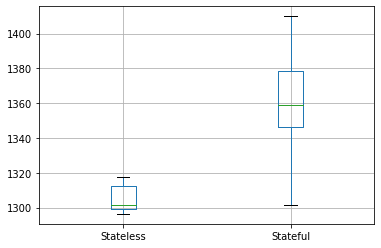

In [44]:
stateless_vs_stateful_lstm_reg.boxplot()

In [45]:
stateless_vs_stateful_lstm_reg.describe()

,Stateless,Stateful
count,10.000000,10.000000
mean,1305.248299,1361.709097
std,7.880703,31.880972
min,1296.323469,1301.438891
25%,1299.199848,1346.124776
50%,1301.640349,1358.655800
75%,1312.450975,1378.504222
max,1317.485696,1409.964454


In [46]:
lstm_reg_stateless_t5_error = pd.concat([
    lstm_reg_stateless_t5_n5.Results,
    lstm_reg_stateless_t5_n10.Results,
    lstm_reg_stateless_t5_n25.Results,
    lstm_reg_stateless_t5_n35.Results,
    lstm_reg_stateless_t5_n50.Results
], axis=1)
lstm_reg_stateless_t5_error.columns =['t5_n5', 't5_n10', 't5_n25', 't5_n35', 't5_n50']

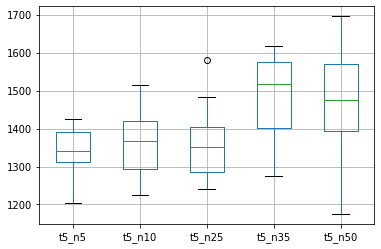

In [47]:
lstm_reg_stateless_t5_error.boxplot()

In [48]:
lstm_reg_stateless_t5_error.describe()

,t5_n5,t5_n10,t5_n25,t5_n35,t5_n50
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1341.649479,1364.527439,1365.439895,1480.479474,1469.183632
std,65.285939,96.839952,104.196054,118.754168,168.914399
min,1203.044806,1225.987727,1242.000440,1275.594045,1174.868344
25%,1311.325742,1292.462473,1286.013702,1401.593100,1393.045786
50%,1340.995737,1366.508110,1352.609684,1518.212282,1474.700948
75%,1392.018015,1418.633603,1403.547919,1575.099009,1570.864990
max,1424.227742,1514.510140,1580.473280,1617.046565,1695.631588


In [49]:
lstm_reg_stateless_t10_error = pd.concat([
    lstm_reg_stateless_t10_n5.Results,
    lstm_reg_stateless_t10_n10.Results,
    lstm_reg_stateless_t10_n25.Results,
    lstm_reg_stateless_t10_n35.Results,
    lstm_reg_stateless_t10_n50.Results
], axis=1)
lstm_reg_stateless_t10_error.columns =['t10_n5', 't10_n10', 't10_n25', 't10_n35', 't10_n50']

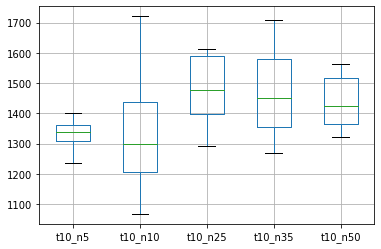

In [50]:
lstm_reg_stateless_t10_error.boxplot()

In [51]:
lstm_reg_stateless_t10_error.describe()

,t10_n5,t10_n10,t10_n25,t10_n35,t10_n50
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1332.587515,1353.504675,1478.593413,1466.897128,1436.067248
std,46.405230,215.137274,114.858982,140.473101,85.653641
min,1234.845519,1067.936747,1293.221340,1270.092133,1320.901338
25%,1309.016967,1207.722226,1396.832455,1356.404983,1365.314648
50%,1339.366938,1298.253252,1476.631769,1450.669238,1423.090360
75%,1361.983660,1436.137125,1588.459923,1580.082048,1515.704536
max,1402.971688,1720.556852,1612.119394,1709.286289,1562.223423


In [52]:
lstm_reg_stateless_t20_error = pd.concat([
    lstm_reg_stateless_t20_n5.Results,
    lstm_reg_stateless_t20_n10.Results,
    lstm_reg_stateless_t20_n25.Results,
    lstm_reg_stateless_t20_n35.Results,
    lstm_reg_stateless_t20_n50.Results
], axis=1)
lstm_reg_stateless_t20_error.columns =['t20_n5', 't20_n10', 't20_n25', 't20_n35', 't20_n50']

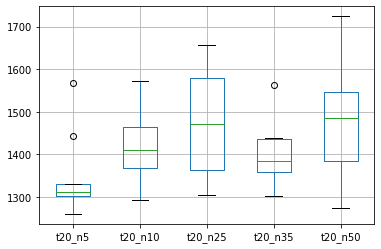

In [53]:
lstm_reg_stateless_t20_error.boxplot()

In [54]:
lstm_reg_stateless_t20_error.describe()

,t20_n5,t20_n10,t20_n25,t20_n35,t20_n50
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1344.339692,1421.100363,1473.077638,1399.178030,1472.877000
std,92.163560,99.629073,129.045744,74.409687,132.325014
min,1260.080936,1292.954018,1304.830136,1301.611708,1275.309036
25%,1301.226515,1367.666081,1364.236013,1358.835539,1384.070825
50%,1311.916956,1410.266654,1470.307619,1385.230239,1484.838012
75%,1329.655416,1465.369585,1578.368136,1435.557634,1547.173129
max,1567.462292,1572.711488,1657.595970,1562.860705,1724.301062


In [55]:
lstm_reg_stateless_t50_error = pd.concat([
    lstm_reg_stateless_t50_n5.Results,
    lstm_reg_stateless_t50_n10.Results,
    lstm_reg_stateless_t50_n25.Results,
    lstm_reg_stateless_t50_n35.Results,
    lstm_reg_stateless_t50_n50.Results
], axis=1)
lstm_reg_stateless_t50_error.columns =['t50_n5', 't50_n10', 't50_n25', 't50_n35', 't50_n50']

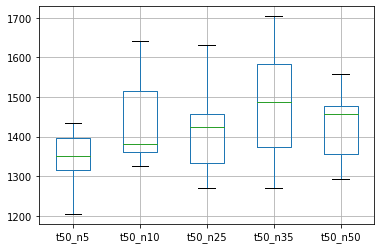

In [56]:
lstm_reg_stateless_t50_error.boxplot()

In [57]:
lstm_reg_stateless_t50_error.describe()

,t50_n5,t50_n10,t50_n25,t50_n35,t50_n50
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1348.714499,1444.350340,1418.338637,1479.149523,1425.366613
std,66.276011,119.966120,110.491929,144.875016,83.721199
min,1204.885304,1326.224016,1271.138933,1270.346513,1294.314713
25%,1314.968239,1361.326061,1333.617156,1373.877618,1355.231466
50%,1350.171453,1381.508378,1424.318098,1487.280866,1456.421721
75%,1397.837582,1514.640281,1456.789032,1583.905174,1476.248091
max,1433.934671,1640.175679,1632.089756,1703.597071,1558.503968


In [58]:
lstm_reg_stateless_t75_error = pd.concat([
    lstm_reg_stateless_t75_n5.Results,
    lstm_reg_stateless_t75_n10.Results,
    lstm_reg_stateless_t75_n25.Results,
    lstm_reg_stateless_t75_n35.Results,
    lstm_reg_stateless_t75_n50.Results
], axis=1)
lstm_reg_stateless_t75_error.columns =['t75_n5', 't75_n10', 't75_n25', 't75_n35', 't75_n50']

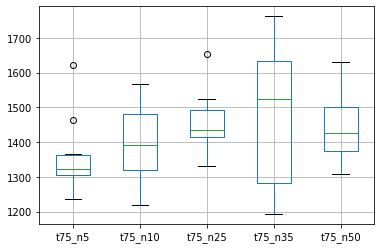

In [59]:
lstm_reg_stateless_t75_error.boxplot()

In [60]:
lstm_reg_stateless_t75_error.describe()

,t75_n5,t75_n10,t75_n25,t75_n35,t75_n50
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1359.817602,1401.369862,1458.439375,1475.591058,1444.719038
std,109.752739,113.404207,87.612287,198.634999,99.535639
min,1237.355505,1219.157269,1330.839126,1192.817265,1307.740583
25%,1305.017192,1318.658793,1415.862568,1282.177150,1373.611635
50%,1323.126169,1391.509411,1436.233480,1523.998366,1427.481231
75%,1362.789739,1480.820338,1491.787200,1634.736282,1501.114470
max,1623.184208,1566.079344,1652.339560,1762.201154,1629.702408


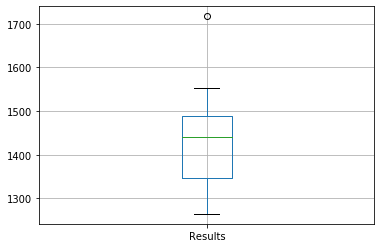

In [61]:
lstm_reg_stateless_2layers_t50_n5.boxplot()

In [62]:
lstm_reg_stateless_1layer_error = pd.concat([
    lstm_reg_stateless_t5_error,
    lstm_reg_stateless_t10_error,
    lstm_reg_stateless_t20_error,
    lstm_reg_stateless_t50_error,
    lstm_reg_stateless_t75_error
], axis=1)

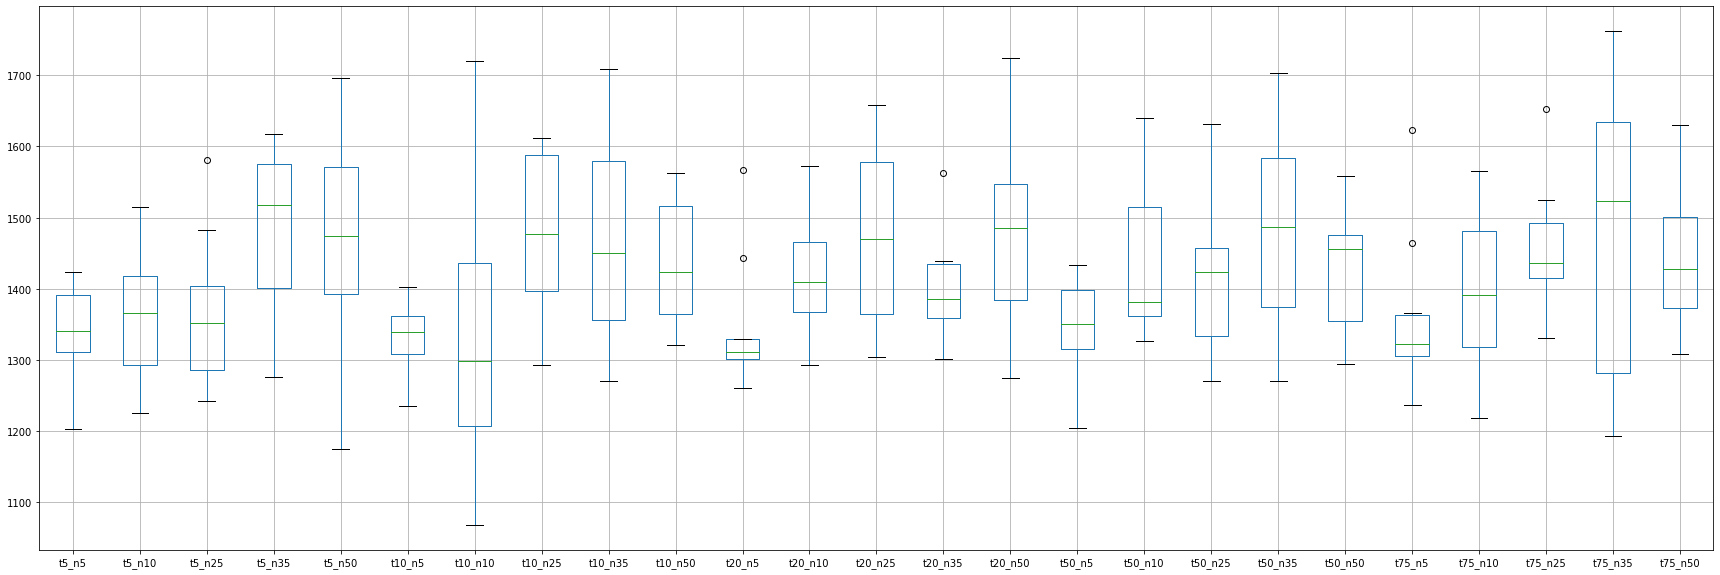

In [63]:
plt.figure(figsize=(30,10))
lstm_reg_stateless_1layer_error.boxplot()

In [64]:
lstm_reg_stateless_1layer_error_average = pd.DataFrame(lstm_reg_stateless_1layer_error.mean().values.reshape(5,5))
lstm_reg_stateless_1layer_error_average.columns = ['n5', 'n10', 'n25', 'n35', 'n50']
lstm_reg_stateless_1layer_error_average.index= ['t5', 't10' , 't20', 't50', 't75']
lstm_reg_stateless_1layer_error_average['Row Average'] = lstm_reg_stateless_1layer_error_average.mean(axis=1)
lstm_reg_stateless_1layer_error_average.loc['Col Average'] = lstm_reg_stateless_1layer_error_average.mean()
lstm_reg_stateless_1layer_error_average

,n5,n10,n25,n35,n50,Row Average
t5,1341.649479,1364.527439,1365.439895,1480.479474,1469.183632,1404.255984
t10,1332.587515,1353.504675,1478.593413,1466.897128,1436.067248,1413.529996
t20,1344.339692,1421.100363,1473.077638,1399.178030,1472.877000,1422.114545
t50,1348.714499,1444.350340,1418.338637,1479.149523,1425.366613,1423.183922
t75,1359.817602,1401.369862,1458.439375,1475.591058,1444.719038,1427.987387
Col Average,1345.421757,1396.970536,1438.777792,1460.259043,1449.642706,1418.214367


In [65]:
lstm_reg_stateless_2layers_t50_n5.describe()

,Results
count,10.000000
mean,1441.742517
std,131.375797
min,1264.407462
25%,1347.609590
50%,1441.042908
75%,1489.765999
max,1717.321567


Unlike random forest even with more timestep LSTM does not seem to get better. However, the more neuron is added to the LSTM model the worst it performs which might led the developer to believe that the model might be overfitting due to over learning the training data with a lot of neurons. The model shown during the model building process is using hyperparameter statelful=False but here a test is done to test whether stateless or stateful is better for this data. The result show that stateless is significantly more consistent and better than stateful model in this case. Thus, every test done after this will be done using stateless configuration. the same timestep data is used and 5, 10, 25, 35 and 50 neurons are tested. The end result shows that the model has the best result when timestep is set to 10. However, a reason this might happen is with such a short timestep LSTM tend to follow the pattern of the few timestep meaning if most of the data is showing an uptrend then it will predict the price will go up and vice versa and because of bitcoin's recent surge and the current market situation it is currently going through it is able to predict a much better result than when a longer timestep is chosen. So to keep it save the developer has chosen timestep of 50 with 5 neurons as the final model's configuration. timestep of 20 is also a strong parameter choice but when looking at the standard deviation of the results of the 10 repeats 50 timesteps has a much lower standard deviation which means the model produces more consistent result even though it is slightly worse. A last test is done to see if 2 layers of LSTM might be able to predict better, the result does not shock the developer as with 2 layers it produces an even worse result which shows the trend of more neurons equals to worse result.

## Random Forest Classification

In [66]:
rf_class_t5_n100 = pd.read_csv('./resource/rf_class_result/rf_class_error_t5_n100.csv', index_col=0)
rf_class_t5_n200 = pd.read_csv('./resource/rf_class_result/rf_class_error_t5_n200.csv', index_col=0)
rf_class_t5_n500 = pd.read_csv('./resource/rf_class_result/rf_class_error_t5_n500.csv', index_col=0)
rf_class_t5_n750 = pd.read_csv('./resource/rf_class_result/rf_class_error_t5_n750.csv', index_col=0)
rf_class_t5_n1000 = pd.read_csv('./resource/rf_class_result/rf_class_error_t5_n1000.csv', index_col=0)

rf_class_t10_n100 = pd.read_csv('./resource/rf_class_result/rf_class_error_t10_n100.csv', index_col=0)
rf_class_t10_n200 = pd.read_csv('./resource/rf_class_result/rf_class_error_t10_n200.csv', index_col=0)
rf_class_t10_n500 = pd.read_csv('./resource/rf_class_result/rf_class_error_t10_n500.csv', index_col=0)
rf_class_t10_n750 = pd.read_csv('./resource/rf_class_result/rf_class_error_t10_n750.csv', index_col=0)
rf_class_t10_n1000 = pd.read_csv('./resource/rf_class_result/rf_class_error_t10_n1000.csv', index_col=0)

rf_class_t20_n100 = pd.read_csv('./resource/rf_class_result/rf_class_error_t20_n100.csv', index_col=0)
rf_class_t20_n200 = pd.read_csv('./resource/rf_class_result/rf_class_error_t20_n200.csv', index_col=0)
rf_class_t20_n500 = pd.read_csv('./resource/rf_class_result/rf_class_error_t20_n500.csv', index_col=0)
rf_class_t20_n750 = pd.read_csv('./resource/rf_class_result/rf_class_error_t20_n750.csv', index_col=0)
rf_class_t20_n1000 = pd.read_csv('./resource/rf_class_result/rf_class_error_t20_n1000.csv', index_col=0)

rf_class_t50_n100 = pd.read_csv('./resource/rf_class_result/rf_class_error_t50_n100.csv', index_col=0)
rf_class_t50_n200 = pd.read_csv('./resource/rf_class_result/rf_class_error_t50_n200.csv', index_col=0)
rf_class_t50_n500 = pd.read_csv('./resource/rf_class_result/rf_class_error_t50_n500.csv', index_col=0)
rf_class_t50_n750 = pd.read_csv('./resource/rf_class_result/rf_class_error_t50_n750.csv', index_col=0)
rf_class_t50_n1000 = pd.read_csv('./resource/rf_class_result/rf_class_error_t50_n1000.csv', index_col=0)

rf_class_t75_n100 = pd.read_csv('./resource/rf_class_result/rf_class_error_t75_n100.csv', index_col=0)
rf_class_t75_n200 = pd.read_csv('./resource/rf_class_result/rf_class_error_t75_n200.csv', index_col=0)
rf_class_t75_n500 = pd.read_csv('./resource/rf_class_result/rf_class_error_t75_n500.csv', index_col=0)
rf_class_t75_n750 = pd.read_csv('./resource/rf_class_result/rf_class_error_t75_n750.csv', index_col=0)
rf_class_t75_n1000 = pd.read_csv('./resource/rf_class_result/rf_class_error_t75_n1000.csv', index_col=0)

In [67]:
rf_class_t5 = pd.concat([
    rf_class_t5_n100,
    rf_class_t5_n200,
    rf_class_t5_n500,
    rf_class_t5_n750,
    rf_class_t5_n1000
], axis=1)
rf_class_t5.columns = ['t5_n100', 't5_n200', 't5_n500', 't5_n750', 't5_n1000']


rf_class_t10 = pd.concat([
    rf_class_t10_n100,
    rf_class_t10_n200,
    rf_class_t10_n500,
    rf_class_t10_n750,
    rf_class_t10_n1000
], axis=1)
rf_class_t10.columns = ['t10_n100', 't10_n200', 't10_n500', 't10_n750', 't10_n1000']

rf_class_t20 = pd.concat([
    rf_class_t20_n100,
    rf_class_t20_n200,
    rf_class_t20_n500,
    rf_class_t20_n750,
    rf_class_t20_n1000
], axis=1)
rf_class_t20.columns = ['t20_n100', 't20_n200', 't20_n500', 't20_n750', 't20_n1000']

rf_class_t50 = pd.concat([
    rf_class_t50_n100,
    rf_class_t50_n200,
    rf_class_t50_n500,
    rf_class_t50_n750,
    rf_class_t50_n1000
], axis=1)
rf_class_t50.columns = ['t50_n100', 't50_n200', 't50_n500', 't50_n750', 't50_n1000']

rf_class_t75 = pd.concat([
    rf_class_t75_n100,
    rf_class_t75_n200,
    rf_class_t75_n500,
    rf_class_t75_n750,
    rf_class_t75_n1000
], axis=1)
rf_class_t75.columns = ['t75_n100', 't75_n200', 't75_n500', 't75_n750', 't75_n1000']

In [68]:
rf_class_t5

,t5_n100,t5_n200,t5_n500,t5_n750,t5_n1000
accuracy,0.633333,0.666667,0.733333,0.733333,0.733333
f1_score,0.744186,0.761905,0.818182,0.818182,0.818182
precision,0.727273,0.761905,0.782609,0.782609,0.782609
recall,0.761905,0.761905,0.857143,0.857143,0.857143


In [69]:
rf_class_t10

,t10_n100,t10_n200,t10_n500,t10_n750,t10_n1000
accuracy,0.800000,0.766667,0.766667,0.766667,0.766667
f1_score,0.857143,0.844444,0.844444,0.844444,0.844444
precision,0.857143,0.791667,0.791667,0.791667,0.791667
recall,0.857143,0.904762,0.904762,0.904762,0.904762


In [70]:
rf_class_t20

,t20_n100,t20_n200,t20_n500,t20_n750,t20_n1000
accuracy,0.700000,0.666667,0.766667,0.766667,0.733333
f1_score,0.790698,0.750000,0.837209,0.844444,0.809524
precision,0.772727,0.789474,0.818182,0.791667,0.809524
recall,0.809524,0.714286,0.857143,0.904762,0.809524


In [71]:
rf_class_t50

,t50_n100,t50_n200,t50_n500,t50_n750,t50_n1000
accuracy,0.533333,0.666667,0.633333,0.633333,0.700000
f1_score,0.650000,0.772727,0.731707,0.744186,0.800000
precision,0.684211,0.739130,0.750000,0.727273,0.750000
recall,0.619048,0.809524,0.714286,0.761905,0.857143


In [72]:
rf_class_t75

,t75_n100,t75_n200,t75_n500,t75_n750,t75_n1000
accuracy,0.500000,0.633333,0.700000,0.700000,0.733333
f1_score,0.615385,0.755556,0.800000,0.800000,0.826087
precision,0.666667,0.708333,0.750000,0.750000,0.760000
recall,0.571429,0.809524,0.857143,0.857143,0.904762


In [73]:
rf_class_error = pd.concat([
    rf_class_t5.loc['accuracy'],
    rf_class_t10.loc['accuracy'],
    rf_class_t20.loc['accuracy'],
    rf_class_t50.loc['accuracy'],
    rf_class_t75.loc['accuracy']
], axis=0)

rf_class_error = pd.DataFrame(rf_class_error.values.reshape(5,5), columns=['n100', 'n200', 'n500', 'n750', 'n1000'], index=['t5', 't10', 't20', 't50', 't75'])
rf_class_error['Row Average'] = rf_class_error.mean(axis=1)
rf_class_error.loc['Column Average'] = rf_class_error.mean()
rf_class_error

,n100,n200,n500,n750,n1000,Row Average
t5,0.633333,0.666667,0.733333,0.733333,0.733333,0.700000
t10,0.800000,0.766667,0.766667,0.766667,0.766667,0.773333
t20,0.700000,0.666667,0.766667,0.766667,0.733333,0.726667
t50,0.533333,0.666667,0.633333,0.633333,0.700000,0.633333
t75,0.500000,0.633333,0.700000,0.700000,0.733333,0.653333
Column Average,0.633333,0.680000,0.720000,0.720000,0.733333,0.697333


Best is t10 n100. Except for t75 n100 the rest of the model seems to be performing better than the persistence model which can be said that the model is able to slightly learn the pattern. t10 n100 is chosen because it produces the best accuracy and also the high precision and recall number supported that the model does not simply randomly predicts but is able to predict true correctly consistently as well.

## LSTM Classification

For LSTM Classification, the previous experiment of comparing stateless vs stateful and the last experiment of comparing 1 layer vs 2 layers with the same amount of neurons used is omitted as it is assumed that the result will be the same that stateless is better for this data and also 2 layers will perform worse than 1 layer.

In [74]:
lstm_class_stateless_t5_n5 = pd.read_csv('./resource/lstm_class_result/lstm_class_t5_n5.csv')
lstm_class_stateless_t5_n10 = pd.read_csv('./resource/lstm_class_result/lstm_class_t5_n10.csv')
lstm_class_stateless_t5_n25 = pd.read_csv('./resource/lstm_class_result/lstm_class_t5_n25.csv')
lstm_class_stateless_t5_n35 = pd.read_csv('./resource/lstm_class_result/lstm_class_t5_n35.csv')
lstm_class_stateless_t5_n50 = pd.read_csv('./resource/lstm_class_result/lstm_class_t5_n50.csv')

lstm_class_stateless_t10_n5 = pd.read_csv('./resource/lstm_class_result/lstm_class_t10_n5.csv')
lstm_class_stateless_t10_n10 = pd.read_csv('./resource/lstm_class_result/lstm_class_t10_n10.csv')
lstm_class_stateless_t10_n25 = pd.read_csv('./resource/lstm_class_result/lstm_class_t10_n25.csv')
lstm_class_stateless_t10_n35 = pd.read_csv('./resource/lstm_class_result/lstm_class_t10_n35.csv')
lstm_class_stateless_t10_n50 = pd.read_csv('./resource/lstm_class_result/lstm_class_t10_n50.csv')

lstm_class_stateless_t20_n5 = pd.read_csv('./resource/lstm_class_result/lstm_class_t20_n5.csv')
lstm_class_stateless_t20_n10 = pd.read_csv('./resource/lstm_class_result/lstm_class_t20_n10.csv')
lstm_class_stateless_t20_n25 = pd.read_csv('./resource/lstm_class_result/lstm_class_t20_n25.csv')
lstm_class_stateless_t20_n35 = pd.read_csv('./resource/lstm_class_result/lstm_class_t20_n35.csv')
lstm_class_stateless_t20_n50 = pd.read_csv('./resource/lstm_class_result/lstm_class_t20_n50.csv')

lstm_class_stateless_t50_n5 = pd.read_csv('./resource/lstm_class_result/lstm_class_t50_n5.csv')
lstm_class_stateless_t50_n10 = pd.read_csv('./resource/lstm_class_result/lstm_class_t50_n10.csv')
lstm_class_stateless_t50_n25 = pd.read_csv('./resource/lstm_class_result/lstm_class_t50_n25.csv')
lstm_class_stateless_t50_n35 = pd.read_csv('./resource/lstm_class_result/lstm_class_t50_n35.csv')
lstm_class_stateless_t50_n50 = pd.read_csv('./resource/lstm_class_result/lstm_class_t50_n50.csv')

lstm_class_stateless_t75_n5 = pd.read_csv('./resource/lstm_class_result/lstm_class_t75_n5.csv')
lstm_class_stateless_t75_n10 = pd.read_csv('./resource/lstm_class_result/lstm_class_t75_n10.csv')
lstm_class_stateless_t75_n25 = pd.read_csv('./resource/lstm_class_result/lstm_class_t75_n25.csv')
lstm_class_stateless_t75_n35 = pd.read_csv('./resource/lstm_class_result/lstm_class_t75_n35.csv')
lstm_class_stateless_t75_n50 = pd.read_csv('./resource/lstm_class_result/lstm_class_t75_n50.csv')

In [75]:
lstm_class_stateless_t5_error = pd.concat([
    lstm_class_stateless_t5_n5[['Accuracy', 'F1_Score', 'Precision', 'Recall']],
    lstm_class_stateless_t5_n10[['Accuracy', 'F1_Score', 'Precision', 'Recall']],
    lstm_class_stateless_t5_n25[['Accuracy', 'F1_Score', 'Precision', 'Recall']],
    lstm_class_stateless_t5_n35[['Accuracy', 'F1_Score', 'Precision', 'Recall']],
    lstm_class_stateless_t5_n50[['Accuracy', 'F1_Score', 'Precision', 'Recall']]
], axis=1)

lstm_class_stateless_t5_error.columns = pd.MultiIndex.from_product([["t5_n5", "t5_n10", "t5_n25", "t5_n35", "t5_n50"], ["Accuracy", "F1_Score", "Precision", "Recall"]])
lstm_class_stateless_t5_error.loc['Average'] = lstm_class_stateless_t5_error.mean()


lstm_class_stateless_t10_error = pd.concat([
    lstm_class_stateless_t10_n5[['Accuracy', 'F1_Score', 'Precision', 'Recall']],
    lstm_class_stateless_t10_n10[['Accuracy', 'F1_Score', 'Precision', 'Recall']],
    lstm_class_stateless_t10_n25[['Accuracy', 'F1_Score', 'Precision', 'Recall']],
    lstm_class_stateless_t10_n35[['Accuracy', 'F1_Score', 'Precision', 'Recall']],
    lstm_class_stateless_t10_n50[['Accuracy', 'F1_Score', 'Precision', 'Recall']]
], axis=1)

lstm_class_stateless_t10_error.columns = pd.MultiIndex.from_product([["t10_n5", "t10_n10", "t10_n25", "t10_n35", "t10_n50"], ["Accuracy", "F1_Score", "Precision", "Recall"]])
lstm_class_stateless_t10_error.loc['Average'] = lstm_class_stateless_t10_error.mean()

lstm_class_stateless_t20_error = pd.concat([
    lstm_class_stateless_t20_n5[['Accuracy', 'F1_Score', 'Precision', 'Recall']],
    lstm_class_stateless_t20_n10[['Accuracy', 'F1_Score', 'Precision', 'Recall']],
    lstm_class_stateless_t20_n25[['Accuracy', 'F1_Score', 'Precision', 'Recall']],
    lstm_class_stateless_t20_n35[['Accuracy', 'F1_Score', 'Precision', 'Recall']],
    lstm_class_stateless_t20_n50[['Accuracy', 'F1_Score', 'Precision', 'Recall']]
], axis=1)

lstm_class_stateless_t20_error.columns = pd.MultiIndex.from_product([["t20_n5", "t20_n10", "t20_n25", "t20_n35", "t20_n50"], ["Accuracy", "F1_Score", "Precision", "Recall"]])
lstm_class_stateless_t20_error.loc['Average'] = lstm_class_stateless_t20_error.mean()

lstm_class_stateless_t50_error = pd.concat([
    lstm_class_stateless_t50_n5[['Accuracy', 'F1_Score', 'Precision', 'Recall']],
    lstm_class_stateless_t50_n10[['Accuracy', 'F1_Score', 'Precision', 'Recall']],
    lstm_class_stateless_t50_n25[['Accuracy', 'F1_Score', 'Precision', 'Recall']],
    lstm_class_stateless_t50_n35[['Accuracy', 'F1_Score', 'Precision', 'Recall']],
    lstm_class_stateless_t50_n50[['Accuracy', 'F1_Score', 'Precision', 'Recall']]
], axis=1)

lstm_class_stateless_t50_error.columns = pd.MultiIndex.from_product([["t50_n5", "t50_n10", "t50_n25", "t50_n35", "t50_n50"], ["Accuracy", "F1_Score", "Precision", "Recall"]])
lstm_class_stateless_t50_error.loc['Average'] = lstm_class_stateless_t50_error.mean()

lstm_class_stateless_t75_error = pd.concat([
    lstm_class_stateless_t75_n5[['Accuracy', 'F1_Score', 'Precision', 'Recall']],
    lstm_class_stateless_t75_n10[['Accuracy', 'F1_Score', 'Precision', 'Recall']],
    lstm_class_stateless_t75_n25[['Accuracy', 'F1_Score', 'Precision', 'Recall']],
    lstm_class_stateless_t75_n35[['Accuracy', 'F1_Score', 'Precision', 'Recall']],
    lstm_class_stateless_t75_n50[['Accuracy', 'F1_Score', 'Precision', 'Recall']]
], axis=1)

lstm_class_stateless_t75_error.columns = pd.MultiIndex.from_product([["t75_n5", "t75_n10", "t75_n25", "t75_n35", "t75_n50"], ["Accuracy", "F1_Score", "Precision", "Recall"]])
lstm_class_stateless_t75_error.loc['Average'] = lstm_class_stateless_t75_error.mean()


In [76]:
lstm_class_stateless_t5_error

t5_n5                                  t5_n10                      \
         Accuracy  F1_Score Precision    Recall  Accuracy  F1_Score Precision   
0        0.866667  0.909091  0.869565  0.952381  0.900000  0.930233  0.909091   
1        0.900000  0.930233  0.909091  0.952381  0.900000  0.930233  0.909091   
2        0.766667  0.820513  0.888889  0.761905  0.833333  0.878049  0.900000   
3        0.866667  0.904762  0.904762  0.904762  0.900000  0.926829  0.950000   
4        0.766667  0.829268  0.850000  0.809524  0.866667  0.909091  0.869565   
5        0.833333  0.878049  0.900000  0.857143  0.900000  0.930233  0.909091   
6        0.933333  0.954545  0.913043  1.000000  0.900000  0.930233  0.909091   
7        0.733333  0.800000  0.842105  0.761905  0.800000  0.842105  0.941176   
8        0.766667  0.829268  0.850000  0.809524  0.866667  0.904762  0.904762   
9        0.800000  0.850000  0.894737  0.809524  0.866667  0.904762  0.904762   
Average  0.823333  0.870573  0.882219  0.861905  0.873333  0.908653  0.910663   

                     t5_n25                                  t5_n35            \
           Recall  Accuracy  F1_Score Precision    Recall  Accuracy  F1_Score   
0        0.952381  0.833333  0.871795  0.944444  0.809524  0.833333  0.878049   
1        0.952381  0.833333  0.871795  0.944444  0.809524  0.900000  0.926829   
2        0.857143  0.833333  0.878049  0.900000  0.857143  0.933333  0.952381   
3        0.904762  0.900000  0.930233  0.909091  0.952381  0.866667  0.909091   
4        0.952381  0.900000  0.926829  0.950000  0.904762  0.933333  0.950000   
5        0.952381  0.933333  0.952381  0.952381  0.952381  0.833333  0.878049   
6        0.952381  0.800000  0.850000  0.894737  0.809524  0.866667  0.900000   
7        0.761905  0.800000  0.857143  0.857143  0.857143  0.866667  0.900000   
8        0.904762  0.833333  0.878049  0.900000  0.857143  0.866667  0.909091   
9        0.904762  0.866667  0.904762  0.904762  0.904762  0.800000  0.857143   
Average  0.909524  0.853333  0.892103  0.915700  0.871429  0.870000  0.906063   

                               t5_n50                                
        Precision    Recall  Accuracy  F1_Score Precision    Recall  
0        0.900000  0.857143  0.866667  0.900000  0.947368  0.857143  
1        0.950000  0.904762  0.933333  0.952381  0.952381  0.952381  
2        0.952381  0.952381  0.833333  0.878049  0.900000  0.857143  
3        0.869565  0.952381  0.800000  0.850000  0.894737  0.809524  
4        1.000000  0.904762  0.733333  0.800000  0.842105  0.761905  
5        0.900000  0.857143  0.900000  0.926829  0.950000  0.904762  
6        0.947368  0.857143  0.900000  0.926829  0.950000  0.904762  
7        0.947368  0.857143  0.866667  0.894737  1.000000  0.809524  
8        0.869565  0.952381  0.733333  0.800000  0.842105  0.761905  
9        0.857143  0.857143  0.800000  0.857143  0.857143  0.857143  
Average  0.919339  0.895238  0.836667  0.878597  0.913584  0.847619

In [77]:
lstm_class_stateless_t10_error

t10_n5                                 t10_n10                      \
         Accuracy  F1_Score Precision    Recall  Accuracy  F1_Score Precision   
0        0.833333  0.871795  0.944444  0.809524  0.833333  0.878049  0.900000   
1        0.866667  0.909091  0.869565  0.952381  0.800000  0.857143  0.857143   
2        0.800000  0.857143  0.857143  0.857143  0.833333  0.883721  0.863636   
3        0.866667  0.909091  0.869565  0.952381  0.866667  0.904762  0.904762   
4        0.800000  0.863636  0.826087  0.904762  0.866667  0.904762  0.904762   
5        0.900000  0.926829  0.950000  0.904762  0.900000  0.930233  0.909091   
6        0.966667  0.976744  0.954545  1.000000  0.866667  0.909091  0.869565   
7        0.833333  0.883721  0.863636  0.904762  0.866667  0.904762  0.904762   
8        0.833333  0.883721  0.863636  0.904762  0.866667  0.894737  1.000000   
9        0.866667  0.904762  0.904762  0.904762  0.933333  0.952381  0.952381   
Average  0.856667  0.898653  0.890338  0.909524  0.863333  0.901964  0.906610   

                    t10_n25                                 t10_n35            \
           Recall  Accuracy  F1_Score Precision    Recall  Accuracy  F1_Score   
0        0.857143  0.833333  0.883721  0.863636  0.904762  0.866667  0.900000   
1        0.857143  0.866667  0.904762  0.904762  0.904762  0.900000  0.926829   
2        0.904762  0.800000  0.850000  0.894737  0.809524  0.866667  0.904762   
3        0.904762  0.900000  0.930233  0.909091  0.952381  0.833333  0.883721   
4        0.904762  0.833333  0.878049  0.900000  0.857143  0.866667  0.904762   
5        0.952381  0.866667  0.904762  0.904762  0.904762  0.900000  0.930233   
6        0.952381  0.800000  0.850000  0.894737  0.809524  0.800000  0.857143   
7        0.904762  0.866667  0.904762  0.904762  0.904762  0.966667  0.976744   
8        0.809524  0.900000  0.926829  0.950000  0.904762  0.866667  0.894737   
9        0.952381  0.900000  0.926829  0.950000  0.904762  0.833333  0.883721   
Average  0.900000  0.856667  0.895995  0.907649  0.885714  0.870000  0.906265   

                              t10_n50                                
        Precision    Recall  Accuracy  F1_Score Precision    Recall  
0        0.947368  0.857143  0.833333  0.878049  0.900000  0.857143  
1        0.950000  0.904762  0.833333  0.878049  0.900000  0.857143  
2        0.904762  0.904762  0.800000  0.857143  0.857143  0.857143  
3        0.863636  0.904762  0.833333  0.871795  0.944444  0.809524  
4        0.904762  0.904762  0.933333  0.952381  0.952381  0.952381  
5        0.909091  0.952381  0.766667  0.820513  0.888889  0.761905  
6        0.857143  0.857143  0.866667  0.904762  0.904762  0.904762  
7        0.954545  1.000000  0.900000  0.930233  0.909091  0.952381  
8        1.000000  0.809524  0.866667  0.904762  0.904762  0.904762  
9        0.863636  0.904762  0.833333  0.878049  0.900000  0.857143  
Average  0.915494  0.900000  0.846667  0.887573  0.906147  0.871429

In [78]:
lstm_class_stateless_t20_error

t20_n5                                 t20_n10                      \
         Accuracy  F1_Score Precision    Recall  Accuracy  F1_Score Precision   
0        0.900000  0.926829  0.950000  0.904762  0.833333  0.878049  0.900000   
1        0.866667  0.900000  0.947368  0.857143  0.833333  0.883721  0.863636   
2        0.800000  0.857143  0.857143  0.857143  0.800000  0.857143  0.857143   
3        0.866667  0.909091  0.869565  0.952381  0.700000  0.769231  0.833333   
4        0.866667  0.909091  0.869565  0.952381  0.900000  0.930233  0.909091   
5        0.833333  0.871795  0.944444  0.809524  0.833333  0.883721  0.863636   
6        0.833333  0.888889  0.833333  0.952381  0.833333  0.883721  0.863636   
7        0.833333  0.883721  0.863636  0.904762  0.966667  0.976744  0.954545   
8        0.800000  0.863636  0.826087  0.904762  0.833333  0.871795  0.944444   
9        0.766667  0.829268  0.850000  0.809524  0.933333  0.952381  0.952381   
Average  0.836667  0.883946  0.881114  0.890476  0.846667  0.888674  0.894185   

                    t20_n25                                 t20_n35            \
           Recall  Accuracy  F1_Score Precision    Recall  Accuracy  F1_Score   
0        0.857143  0.900000  0.926829  0.950000  0.904762  0.900000  0.926829   
1        0.904762  0.766667  0.829268  0.850000  0.809524  0.833333  0.878049   
2        0.857143  0.800000  0.850000  0.894737  0.809524  0.900000  0.933333   
3        0.714286  0.866667  0.900000  0.947368  0.857143  0.900000  0.926829   
4        0.952381  0.900000  0.926829  0.950000  0.904762  0.766667  0.820513   
5        0.904762  0.866667  0.904762  0.904762  0.904762  0.833333  0.888889   
6        0.904762  0.866667  0.900000  0.947368  0.857143  0.900000  0.923077   
7        1.000000  0.966667  0.976744  0.954545  1.000000  0.833333  0.888889   
8        0.809524  0.866667  0.904762  0.904762  0.904762  0.900000  0.926829   
9        0.952381  0.866667  0.904762  0.904762  0.904762  0.766667  0.837209   
Average  0.885714  0.866667  0.902396  0.920830  0.885714  0.853333  0.895045   

                              t20_n50                                
        Precision    Recall  Accuracy  F1_Score Precision    Recall  
0        0.950000  0.904762  0.833333  0.878049  0.900000  0.857143  
1        0.900000  0.857143  0.800000  0.850000  0.894737  0.809524  
2        0.875000  1.000000  0.833333  0.871795  0.944444  0.809524  
3        0.950000  0.904762  0.900000  0.923077  1.000000  0.857143  
4        0.888889  0.761905  0.833333  0.883721  0.863636  0.904762  
5        0.833333  0.952381  0.800000  0.857143  0.857143  0.857143  
6        1.000000  0.857143  0.933333  0.952381  0.952381  0.952381  
7        0.833333  0.952381  0.900000  0.926829  0.950000  0.904762  
8        0.950000  0.904762  0.866667  0.894737  1.000000  0.809524  
9        0.818182  0.857143  0.866667  0.894737  1.000000  0.809524  
Average  0.899874  0.895238  0.856667  0.893247  0.936234  0.857143

In [79]:
lstm_class_stateless_t50_error

t50_n5                                 t50_n10                      \
         Accuracy  F1_Score Precision    Recall  Accuracy  F1_Score Precision   
0        0.800000  0.857143  0.857143  0.857143  0.866667  0.909091  0.869565   
1        0.833333  0.878049  0.900000  0.857143  0.866667  0.904762  0.904762   
2        0.833333  0.864865  1.000000  0.761905  0.833333  0.871795  0.944444   
3        0.733333  0.800000  0.842105  0.761905  0.933333  0.952381  0.952381   
4        0.766667  0.820513  0.888889  0.761905  0.866667  0.904762  0.904762   
5        0.800000  0.842105  0.941176  0.761905  0.866667  0.900000  0.947368   
6        0.966667  0.976744  0.954545  1.000000  0.800000  0.857143  0.857143   
7        0.800000  0.850000  0.894737  0.809524  0.866667  0.909091  0.869565   
8        0.866667  0.909091  0.869565  0.952381  0.833333  0.878049  0.900000   
9        0.900000  0.930233  0.909091  0.952381  0.833333  0.883721  0.863636   
Average  0.830000  0.872874  0.905725  0.847619  0.856667  0.897079  0.901363   

                    t50_n25                                 t50_n35            \
           Recall  Accuracy  F1_Score Precision    Recall  Accuracy  F1_Score   
0        0.952381  0.833333  0.878049  0.900000  0.857143  0.766667  0.844444   
1        0.904762  0.733333  0.800000  0.842105  0.761905  0.800000  0.857143   
2        0.809524  0.833333  0.871795  0.944444  0.809524  0.900000  0.926829   
3        0.952381  0.800000  0.857143  0.857143  0.857143  0.800000  0.842105   
4        0.904762  0.866667  0.904762  0.904762  0.904762  0.900000  0.923077   
5        0.857143  0.866667  0.900000  0.947368  0.857143  0.866667  0.900000   
6        0.857143  0.833333  0.871795  0.944444  0.809524  0.766667  0.820513   
7        0.952381  0.833333  0.871795  0.944444  0.809524  0.933333  0.950000   
8        0.857143  0.833333  0.871795  0.944444  0.809524  0.900000  0.926829   
9        0.904762  0.833333  0.883721  0.863636  0.904762  0.833333  0.878049   
Average  0.895238  0.826667  0.871085  0.909279  0.838095  0.846667  0.886899   

                              t50_n50                                
        Precision    Recall  Accuracy  F1_Score Precision    Recall  
0        0.791667  0.904762  0.933333  0.952381  0.952381  0.952381  
1        0.857143  0.857143  0.900000  0.926829  0.950000  0.904762  
2        0.950000  0.904762  0.866667  0.900000  0.947368  0.857143  
3        0.941176  0.761905  0.733333  0.800000  0.842105  0.761905  
4        1.000000  0.857143  0.900000  0.930233  0.909091  0.952381  
5        0.947368  0.857143  0.766667  0.829268  0.850000  0.809524  
6        0.888889  0.761905  0.833333  0.871795  0.944444  0.809524  
7        1.000000  0.904762  0.833333  0.878049  0.900000  0.857143  
8        0.950000  0.904762  0.833333  0.878049  0.900000  0.857143  
9        0.900000  0.857143  0.800000  0.842105  0.941176  0.761905  
Average  0.922624  0.857143  0.840000  0.880871  0.913657  0.852381

In [80]:
lstm_class_stateless_t75_error

t75_n5                                 t75_n10                      \
         Accuracy  F1_Score Precision    Recall  Accuracy  F1_Score Precision   
0        0.833333  0.871795  0.944444  0.809524  0.833333  0.878049  0.900000   
1        0.900000  0.926829  0.950000  0.904762  0.833333  0.878049  0.900000   
2        0.800000  0.850000  0.894737  0.809524  0.800000  0.850000  0.894737   
3        0.866667  0.900000  0.947368  0.857143  0.933333  0.952381  0.952381   
4        0.800000  0.857143  0.857143  0.857143  0.833333  0.878049  0.900000   
5        0.700000  0.780488  0.800000  0.761905  0.900000  0.926829  0.950000   
6        0.800000  0.850000  0.894737  0.809524  0.900000  0.930233  0.909091   
7        0.866667  0.900000  0.947368  0.857143  0.733333  0.800000  0.842105   
8        0.900000  0.926829  0.950000  0.904762  0.800000  0.850000  0.894737   
9        0.866667  0.900000  0.947368  0.857143  0.800000  0.850000  0.894737   
Average  0.833333  0.876308  0.913317  0.842857  0.836667  0.879359  0.903779   

                    t75_n25                                 t75_n35            \
           Recall  Accuracy  F1_Score Precision    Recall  Accuracy  F1_Score   
0        0.857143  0.800000  0.857143  0.857143  0.857143  0.800000  0.850000   
1        0.857143  0.866667  0.900000  0.947368  0.857143  0.833333  0.878049   
2        0.809524  0.766667  0.837209  0.818182  0.857143  0.766667  0.829268   
3        0.952381  0.833333  0.871795  0.944444  0.809524  0.800000  0.863636   
4        0.857143  0.833333  0.883721  0.863636  0.904762  0.900000  0.930233   
5        0.904762  0.866667  0.904762  0.904762  0.904762  0.833333  0.871795   
6        0.952381  0.800000  0.857143  0.857143  0.857143  0.800000  0.857143   
7        0.761905  0.866667  0.894737  1.000000  0.809524  0.866667  0.909091   
8        0.809524  0.866667  0.909091  0.869565  0.952381  0.900000  0.926829   
9        0.809524  0.800000  0.857143  0.857143  0.857143  0.866667  0.909091   
Average  0.857143  0.830000  0.877274  0.891939  0.866667  0.836667  0.882513   

                              t75_n50                                
        Precision    Recall  Accuracy  F1_Score Precision    Recall  
0        0.894737  0.809524  0.733333  0.777778  0.933333  0.666667  
1        0.900000  0.857143  0.800000  0.850000  0.894737  0.809524  
2        0.850000  0.809524  0.866667  0.904762  0.904762  0.904762  
3        0.826087  0.904762  0.800000  0.850000  0.894737  0.809524  
4        0.909091  0.952381  0.833333  0.878049  0.900000  0.857143  
5        0.944444  0.809524  0.766667  0.820513  0.888889  0.761905  
6        0.857143  0.857143  0.866667  0.904762  0.904762  0.904762  
7        0.869565  0.952381  0.866667  0.900000  0.947368  0.857143  
8        0.950000  0.904762  0.833333  0.878049  0.900000  0.857143  
9        0.869565  0.952381  0.866667  0.904762  0.904762  0.904762  
Average  0.887063  0.880952  0.823333  0.866867  0.907335  0.833333

In [81]:
lstm_class_error = pd.concat([
    lstm_class_stateless_t5_error.xs('Accuracy', level=1, axis=1).loc['Average'],
    lstm_class_stateless_t10_error.xs('Accuracy', level=1, axis=1).loc['Average'],
    lstm_class_stateless_t20_error.xs('Accuracy', level=1, axis=1).loc['Average'],
    lstm_class_stateless_t50_error.xs('Accuracy', level=1, axis=1).loc['Average'],
    lstm_class_stateless_t75_error.xs('Accuracy', level=1, axis=1).loc['Average'] 
])
print("Accuracy")
pd.DataFrame(lstm_class_error.values.reshape(5,5), columns=['n5', 'n10', 'n25', 'n35', 'n50'], index=['t5', 't10', 't20', 't50' ,'t75'])


Accuracy


,n5,n10,n25,n35,n50
t5,0.823333,0.873333,0.853333,0.870000,0.836667
t10,0.856667,0.863333,0.856667,0.870000,0.846667
t20,0.836667,0.846667,0.866667,0.853333,0.856667
t50,0.830000,0.856667,0.826667,0.846667,0.840000
t75,0.833333,0.836667,0.830000,0.836667,0.823333


In [82]:
lstm_class_f1_score = pd.concat([
    lstm_class_stateless_t5_error.xs('F1_Score', level=1, axis=1).loc['Average'],
    lstm_class_stateless_t10_error.xs('F1_Score', level=1, axis=1).loc['Average'],
    lstm_class_stateless_t20_error.xs('F1_Score', level=1, axis=1).loc['Average'],
    lstm_class_stateless_t50_error.xs('F1_Score', level=1, axis=1).loc['Average'],
    lstm_class_stateless_t75_error.xs('F1_Score', level=1, axis=1).loc['Average'] 
])

print("F1_Score")
pd.DataFrame(lstm_class_f1_score.values.reshape(5,5), columns=['n5', 'n10', 'n25', 'n35', 'n50'], index=['t5', 't10', 't20', 't50' ,'t75'])

F1_Score


,n5,n10,n25,n35,n50
t5,0.870573,0.908653,0.892103,0.906063,0.878597
t10,0.898653,0.901964,0.895995,0.906265,0.887573
t20,0.883946,0.888674,0.902396,0.895045,0.893247
t50,0.872874,0.897079,0.871085,0.886899,0.880871
t75,0.876308,0.879359,0.877274,0.882513,0.866867


In [83]:
lstm_class_precision = pd.concat([
    lstm_class_stateless_t5_error.xs('Precision', level=1, axis=1).loc['Average'],
    lstm_class_stateless_t10_error.xs('Precision', level=1, axis=1).loc['Average'],
    lstm_class_stateless_t20_error.xs('Precision', level=1, axis=1).loc['Average'],
    lstm_class_stateless_t50_error.xs('Precision', level=1, axis=1).loc['Average'],
    lstm_class_stateless_t75_error.xs('Precision', level=1, axis=1).loc['Average'] 
])

print("Precision")
pd.DataFrame(lstm_class_precision.values.reshape(5,5), columns=['n5', 'n10', 'n25', 'n35', 'n50'], index=['t5', 't10', 't20', 't50' ,'t75'])

Precision


,n5,n10,n25,n35,n50
t5,0.882219,0.910663,0.915700,0.919339,0.913584
t10,0.890338,0.906610,0.907649,0.915494,0.906147
t20,0.881114,0.894185,0.920830,0.899874,0.936234
t50,0.905725,0.901363,0.909279,0.922624,0.913657
t75,0.913317,0.903779,0.891939,0.887063,0.907335


In [84]:
lstm_class_recall = pd.concat([
    lstm_class_stateless_t5_error.xs('Recall', level=1, axis=1).loc['Average'],
    lstm_class_stateless_t10_error.xs('Recall', level=1, axis=1).loc['Average'],
    lstm_class_stateless_t20_error.xs('Recall', level=1, axis=1).loc['Average'],
    lstm_class_stateless_t50_error.xs('Recall', level=1, axis=1).loc['Average'],
    lstm_class_stateless_t75_error.xs('Recall', level=1, axis=1).loc['Average'] 
])

print("Recall")
pd.DataFrame(lstm_class_recall.values.reshape(5,5), columns=['n5', 'n10', 'n25', 'n35', 'n50'], index=['t5', 't10', 't20', 't50' ,'t75'])

Recall


,n5,n10,n25,n35,n50
t5,0.861905,0.909524,0.871429,0.895238,0.847619
t10,0.909524,0.900000,0.885714,0.900000,0.871429
t20,0.890476,0.885714,0.885714,0.895238,0.857143
t50,0.847619,0.895238,0.838095,0.857143,0.852381
t75,0.842857,0.857143,0.866667,0.880952,0.833333


# Profitability Analysis

The strategy used for this profitability analysis will be as such:

1. The test data used will be much longer than the test data originally used for model evaluation as longer testing provide a more accurate result to see how the model would fare in real-life
2. An initial capital of $500,000 will be given to each model
3. Model will perform a buy order with all the available money if price is predicted to go up the next day
4. Model will perform a sell order of all its available bitcoin if price is predicted to go down the next day
5. Model will hold its bitcoin if it no longer has any money left to purchase if price is predicted to go up the next day
6. Model will hold its capital if it no longer has any bitcoin and price is predicted to go down the next day

In [85]:
def profit_analysis_logic(bitcoin, capital, diff_y_pred, y_test, tax=0):
    buy_tax = 1 + tax 
    sell_tax = 1 - tax 
    if diff_y_pred > 0: 
        if capital != 0:            
            bitcoin = capital / (y_test * buy_tax)
            capital = 0  
        else:
            pass
    else:
        if bitcoin > 0:
            capital = capital + (bitcoin * y_test * sell_tax) 
            bitcoin = 0
        else:
            pass
    return bitcoin, capital

## Benchmark - Buy and Hold Strategy

In [86]:
def buy_and_hold(bitcoin=0 , capital=500000, n_test=100, tax=0):
    buy_tax = 1 + tax
    sell_tax = 1 - tax
    ori_y_test_values = reg_data.values[-(n_test+1):-1, -1]
    # Initial Buying
    bitcoin = bitcoin + (capital / (ori_y_test_values[0] * buy_tax))
    # Holding
    # ------
    # Selling at the end of the test data
    capital = capital + (bitcoin * ori_y_test_values[-1] * sell_tax)
    return capital

tax_list = [0, 0.001, 0.005, 0.01, 0.02]
for i in tax_list:
    end_capital = buy_and_hold(tax=i)
    ROI = (end_capital - 500000) / 500000 * 100
    print(f'{i*100}% Tax \nBuy and Hold Strategy End Capital: {end_capital}')
    print(f'ROI: {ROI}\n\n')


0% Tax 
Buy and Hold Strategy End Capital: 1706090.5452519243
ROI: 241.21810905038487


0.1% Tax 
Buy and Hold Strategy End Capital: 1703680.7739327396
ROI: 240.7361547865479


0.5% Tax 
Buy and Hold Strategy End Capital: 1694089.644304144
ROI: 238.8179288608288


1.0% Tax 
Buy and Hold Strategy End Capital: 1682207.5641578264
ROI: 236.4415128315653


2.0% Tax 
Buy and Hold Strategy End Capital: 1658792.8768106722
ROI: 231.75857536213448




## Random Forest Regression

In [87]:
def forecast_random_forest_regression(model, X_test):
    y_pred = model.predict(X_test)
    return y_pred[0]

def fit_random_forest_regression(X_train, y_train, n_estimators):
    random_forest = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, random_state=1)
    model  = TransformedTargetRegressor(regressor=random_forest, transformer=MinMaxScaler())
    model.fit(X_train, y_train)
    return model

def experiment_rf_reg_profit_analysis(n_timesteps, n_estimators, n_test, data, n_features, tax):
    raw_values = data.values
    diff_values = difference(raw_values, 1)
    supervised_values = timeseries_to_supervised(diff_values, data.columns, n_timesteps)
    X_train, X_test, y_train, y_test = train_test_split(supervised_values, n_timesteps, n_features, n_test)
    # Apply MinMaxScaler to X data. Scaling for y data will be handled by meta-estimator TransformedTargetRegressor
    X_scaler, X_train, X_test = minmax_scale(X_train, X_test)
    # Copy train data 
    X_train_copy = np.copy(X_train)
    y_train_copy = np.copy(y_train)
    
    # Original y values taken from -101 to -1. Because the model is predicting current day, we are buying using t-1 day value
    ori_y_test_values = data.values[-(n_test+1):-1, -1] 
    
    capital = 500000
    bitcoin = 0
    # Walk-Forward Validation
    for i in range(n_test):
        model = fit_random_forest_regression(X_train_copy, y_train_copy, n_estimators)
        X_test_copy = X_test[i].reshape(1, X_test.shape[1])
        y_pred = forecast_random_forest_regression(model, X_test_copy)
        print(f'Test Data {i+1}\n----  y_pred: {y_pred}  ----')
        bitcoin, capital = profit_analysis_logic(bitcoin, capital, y_pred, ori_y_test_values[i], tax)
        y_pred = inverse_difference(raw_values[:, -1], y_pred, n_test+1-i)
        X_train_copy = concatenate((X_train_copy, X_test[i].reshape(1, X_test.shape[1])))
        y_train_copy = concatenate((y_train_copy, y_test[i].reshape(1)))
        print(f'Current Bitcoin {bitcoin}\nCurrent Capital: {capital}\n')
        
    print("End Result. Cashing out bitcoin.")
    sell_tax = 1 - tax
    capital = capital + (bitcoin * ori_y_test_values[-1] * sell_tax)
    print(f"End Capital: {capital}")
    return capital

def run_rf_reg_profit_analysis(n_timesteps=75, n_estimators=100, n_test=100, data=reg_data, tax=0):
    n_features = len(data.columns) # 11 features
    capital = experiment_rf_reg_profit_analysis(n_timesteps, n_estimators, n_test, data, n_features, tax)
    return capital

# tax_list = [0, 0.001, 0.005, 0.01, 0.02]
# for i in tax_list:
#     capital = run_rf_reg_profit_analysis(n_timesteps=75, n_estimators=100, n_test=100, data=reg_data, tax=i)
#     pd.DataFrame({'Random Forest Regression Profitability Analysis': capital}, index=['Capital']).to_csv(f"rf_reg_profit_analysis_result_tax{i}.csv")

## LSTM Regression

In [88]:
def forecast_lstm_regression(model, batch_size, X_test):
    X_test = X_test.reshape((1, X_test.shape[0], X_test.shape[1])) 
    y_pred = model.predict(X_test, batch_size=batch_size)
    return y_pred

def update_lstm_regression(model, X_train, y_train, batch_size, updates):
    model.fit(X_train, y_train, epochs=updates, batch_size=batch_size, verbose=0, shuffle=False)

def fit_lstm_regression(X_train, y_train, batch_size=100, n_epochs=50, neurons=50):
    model=Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), stateful=False))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose=0, shuffle=False)
    return model

def experiment_lstm_regression_profit_analysis(repeats, data, updates, n_timesteps, n_features, n_test, n_epochs, neurons, tax):
    raw_values = data.values
    diff_values = difference(raw_values, 1)
    supervised_values = timeseries_to_supervised(diff_values, data.columns, n_timesteps)
    X_train, X_test, y_train, y_test = train_test_split(supervised_values, n_timesteps, n_features, n_test)
    # Apply MinMaxScaler to both X and y data
    X_scaler, X_train, X_test = minmax_scale(X_train, X_test)
    y_scaler, y_train, y_test = minmax_scale(y_train, y_test)
    # Reshape X data to 3 dimensional as per LSTM input requirement
    X_train = X_train.reshape((X_train.shape[0], n_timesteps, n_features))
    X_test = X_test.reshape((X_test.shape[0], n_timesteps, n_features))
    
    # Original y values taken from -101 to -1. Because the model is predicting current day, we are buying using t-1 day value
    ori_y_test_values = data.values[-(n_test+1):-1, -1]

    # Repeatedly train and test LSTM model to eliminate outlier results
    end_capitals = list()
    
    for r in range(repeats):
        print(f'Stateless Repeat {r}. Initial Fit Model. neurons: {neurons}')
        lstm_model = fit_lstm_regression(X_train, y_train, batch_size=1, n_epochs=n_epochs, neurons=neurons) 
        # Copy train data so tested data from walk-forward validation can be appended
        X_train_copy = np.copy(X_train)
        y_train_copy = np.copy(y_train)  
        
        # Walk-Forward Validation
        capital = 500000
        bitcoin = 0 
        for i in range(n_test):  
            if i > 0:
                print(f'Stateless Repeat {r}. Test Data: {i}. neurons: {neurons}')
                update_lstm_regression(lstm_model, X_train_copy, y_train_copy, 1, updates)
            X_test_copy = X_test[i]
            y_pred = forecast_lstm_regression(lstm_model, 1, X_test_copy)
            y_pred = inverse_minmax_scale(y_scaler, y_pred)
            y_pred = y_pred[0][0] # inverse_scale return a 2-d ndarray
            print(f'Test Data {i+1}\n----  y_pred: {y_pred}  ----')
            bitcoin, capital = profit_analysis_logic(bitcoin, capital, y_pred, ori_y_test_values[i], tax)
            y_pred = inverse_difference(raw_values[:, -1], y_pred, n_test+1-i)
            X_train_copy = concatenate((X_train_copy, X_test[i].reshape(1, X_test.shape[1], X_test.shape[2])))        
            y_train_copy = concatenate((y_train_copy, y_test[i].reshape(1, y_test.shape[1])))
            print(f'Current Bitcoin {bitcoin}\nCurrent Capital: {capital}\n')
        # Report Performance
        print("End Result. Cashing out bitcoin.")
        sell_tax = 1 - tax
        capital = capital + (bitcoin * ori_y_test_values[-1]* sell_tax)
        print(f"End Capital: {capital}")
        end_capitals.append(capital)
        
    return end_capitals   
    
def run_lstm_regression_profit_analysis(n_timesteps=50, n_epochs=5, neurons=5, repeats=1, updates=5, n_test=100, data=reg_data, tax=0):
    results = pd.DataFrame()
    n_features = len(data.columns) # 10
    results['Results'] = experiment_lstm_regression_profit_analysis(
        repeats,
        data,
        updates,
        n_timesteps,
        n_features,
        n_test,
        n_epochs,
        neurons
    )
    
    return results

# tax_list = [0, 0.001, 0.005, 0.01, 0.02]
# for i in tax_list:
#     result = run_lstm_regression_profit_analysis(n_timesteps=50, n_epochs=5, neurons=5, repeats=1, updates=5, n_test=100, tax=i)
#     result.to_csv(f'lstm_reg_profit_analysis_result_tax{i}.csv', index=False)

## Random Forest Classfication

In [89]:
def forecast_random_forest_classification(model, X_test):
    y_pred = model.predict(X_test)
    return y_pred[0]

def fit_random_forest_classification(X_train, y_train, n_estimators=500):
    model = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1, random_state=1)
    model.fit(X_train, y_train)
    return model

def experiment_rf_class_profit_analysis(n_timesteps, n_estimators, n_test, data, n_features, tax):    
    supervised_values = timeseries_to_supervised(data, data.columns, n_timesteps)
    X_train, X_test, y_train, y_test = train_test_split(supervised_values, n_timesteps, n_features, n_test)
    # Apply minmax scaler to column Low, High, Open and Close
    X_scaler, X_train[:, [1,2,4,5]], X_test[: ,[1,2,4,5]] = minmax_scale(X_train[:, [1,2,4,5]], X_test[:, [1,2,4,5]])
    # Copy train data 
    X_train_copy = np.copy(X_train)
    y_train_copy = np.copy(y_train)
    
    # Original y values taken from -101 to -1. Because the model is predicting current day, we are buying using t-1 day value
    # Also uses reg_data instead of class_data because we need the original weighted_price value.
    ori_y_test_values = reg_data.values[-(n_test+1):-1, -1]
    
    capital = 500000
    bitcoin = 0
    # Walk-Forward Validation
    for i in range(n_test):
        model = fit_random_forest_classification(X_train_copy, y_train_copy, n_estimators)
        X_test_copy = X_test[i].reshape(1, X_test.shape[1])
        y_pred = forecast_random_forest_classification(model, X_test_copy)
        print(f'Test Data {i+1}\n----  y_pred: {y_pred}  ----')
        bitcoin, capital = profit_analysis_logic(bitcoin, capital, y_pred, ori_y_test_values[i], tax)
        X_train_copy = concatenate((X_train_copy, X_test[i].reshape(1, X_test.shape[1])))
        y_train_copy = concatenate((y_train_copy, y_test[i].reshape(1)))
        print(f'Current Bitcoin {bitcoin}\nCurrent Capital: {capital}\n')
    
    print("End Result. Cashing out bitcoin.")
    sell_tax = 1 - tax
    capital = capital + (bitcoin * ori_y_test_values[-1] * sell_tax)
    print(f"End Capital: {capital}")
    
    return capital

def run_rf_class_profit_analysis(n_timesteps=10, n_estimators=100, n_test=100, data=class_data, tax=0):
    n_features = len(data.columns) # 7 features
    capital = experiment_rf_class_profit_analysis(n_timesteps, n_estimators, n_test, data, n_features, tax)
    return capital

# tax_list = [0, 0.001, 0.005, 0.01, 0.02]
# for i in tax_list:
#     capital = run_rf_class_profit_analysis(n_timesteps=10, n_estimators=100, n_test=100, data=class_data, tax=i)
#     pd.DataFrame({'RF Class Profit Analysis Result': capital}, index=['Capital']).to_csv(f'rf_class_profit_analysis_result_tax{i}.csv')

## LSTM Classification

In [90]:
def forecast_lstm_classification(model, batch_size, X_test):
    X_test = X_test.reshape((1, X_test.shape[0], X_test.shape[1])) 
    y_pred = model.predict_classes(X_test, batch_size=batch_size)
    return y_pred

def update_lstm_classification(model, X_train, y_train, batch_size, updates):
    model.fit(X_train, y_train, epochs=updates, batch_size=batch_size, verbose=0, shuffle=False)

def fit_lstm_classification(X_train, y_train, batch_size=100, n_epochs=50, neurons=50):
    model=Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), stateful=False))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose=0, shuffle=False)
    return model

def experiment_lstm_class_profit_analysis(repeats, data, updates, n_timesteps, n_features, n_test, n_epochs, neurons, tax):
    supervised_values = timeseries_to_supervised(data, data.columns, n_timesteps)
    X_train, X_test, y_train, y_test = train_test_split(supervised_values, n_timesteps, n_features, n_test)
    # Apply minmax scaler to column Low, High, Open and Close
    X_scaler, X_train[:, [1,2,4,5]], X_test[: ,[1,2,4,5]] = minmax_scale(X_train[:, [1,2,4,5]], X_test[:, [1,2,4,5]])
    # Reshape X data to 3 dimensional as per LSTM input requirement
    X_train = X_train.reshape((X_train.shape[0], n_timesteps, n_features))
    X_test = X_test.reshape((X_test.shape[0], n_timesteps, n_features))
    # Reset y_test to original data without any pre-processing 
    ori_y_test_values = reg_data.values[-(n_test+1):-1, -1]

    # Repeatedly train and test LSTM model to eliminate outlier results
    end_capitals = list()
    
    for r in range(repeats):
        print(f'Stateless Repeat {r}. Initial Fit Model. neurons: {neurons}')
        lstm_model = fit_lstm_classification(X_train, y_train, batch_size=1, n_epochs=n_epochs, neurons=neurons) 
        # Copy train data so tested data from walk-forward validation can be appended
        X_train_copy = np.copy(X_train)
        y_train_copy = np.copy(y_train)  
        
        # Walk-Forward Validation
        
        capital = 500000
        bitcoin = 0
        for i in range(n_test):  
            if i > 0:
                print(f'Stateless Repeat {r}. Test Data: {i}. neurons: {neurons}')
                update_lstm_classification(lstm_model, X_train_copy, y_train_copy, 1, updates)
            X_test_copy = X_test[i]
            y_pred = forecast_lstm_classification(lstm_model, 1, X_test_copy)
            y_pred = y_pred[0][0]
            print(f'Test Data {i+1}\n----  y_pred: {y_pred}  ----')
            bitcoin, capital = profit_analysis_logic(bitcoin, capital, y_pred, ori_y_test_values[i], tax)
            X_train_copy = concatenate((X_train_copy, X_test[i].reshape(1, X_test.shape[1], X_test.shape[2])))        
            y_train_copy = concatenate((y_train_copy, y_test[i].reshape(1)))
            print(f'Current Bitcoin {bitcoin}\nCurrent Capital: {capital}\n')
            
        # Report Performance
        print("End Result. Cashing out bitcoin.")
        sell_tax = 1 - tax
        capital = capital + (bitcoin * ori_y_test_values[-1] * sell_tax)
        print(f"End Capital: {capital}")
        end_capitals.append(capital)
        
    return end_capitals
       
    
def run_lstm_class_profit_analysis(n_timesteps=20, n_epochs=5, neurons=25, repeats=1, updates=5, n_test=100, data=class_data, tax=0):
    results = pd.DataFrame()
    n_features = len(data.columns) # 7 features
    results['Results'] = experiment_lstm_class_profit_analysis(
        repeats,
        data,
        updates,
        n_timesteps,
        n_features,
        n_test,
        n_epochs,
        neurons,
        tax
    )
    
    return results

# tax_list = [0, 0.001, 0.005, 0.01, 0.02]
# for i in tax_list:
#     result = run_lstm_class_profit_analysis(n_timesteps=20, n_epochs=5, neurons=25, repeats=1, updates=5, n_test=100, tax=i)
#     result.to_csv(f'lstm_class_profit_analysis_result_tax{i}.csv', index=False)

## Results

In [91]:
rf_reg_profit_analysis_result = pd.read_csv('./resource/profitability_analysis/rf_reg_profit_analysis_result.csv')
lstm_reg_profit_analysis_result = pd.read_csv('./resource/profitability_analysis/lstm_reg_profit_analysis_result.csv')
rf_class_profit_analysis_result = pd.read_csv('./resource/profitability_analysis/rf_class_profit_analysis_result.csv')
lstm_class_profit_analysis_result = pd.read_csv('./resource/profitability_analysis/lstm_class_profit_analysis_result.csv')
profit_analysis_results = pd.concat([
    rf_reg_profit_analysis_result,
    lstm_reg_profit_analysis_result,
    rf_class_profit_analysis_result,
    lstm_class_profit_analysis_result
])
profit_analysis_results.index = ['rf_reg', 'lstm_reg', 'rf_class', 'lstm_class']
profit_analysis_results

,tax0,tax0.001,tax0.005,tax0.01,tax0.02
rf_reg,9.617022e+05,9.203047e+05,7.717827e+05,6.193621e+05,398850.8166
lstm_reg,1.058303e+06,1.047116e+06,9.158420e+05,5.999421e+05,323215.4377
rf_class,1.523324e+06,1.446135e+06,1.174559e+06,9.056316e+05,538351.2342
lstm_class,2.343779e+06,1.837936e+06,1.142382e+06,1.304047e+06,879357.9285


In [127]:
class_data.iloc[-30:, -1].to_json('./fyp_website/src/data/realbtcclassprice.json', orient='split', date_format='iso')

In [ ]:
pd.read_csv('./resource/rf_predictions')

In [132]:
a = [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1]
pd.Series(a).to_json('./fyp_website/src/data/lstmclass.json', orient='split')